In [1]:
#Basic Computation
import numpy as np
from numpy import arange
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
#Feature Selection Metrics
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
from minepy import MINE
from minepy import cstats

#Preprocessing and performance evaluation
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import log,pi,hypot,fabs,sqrt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# grid search hyperparameters for ridge regression
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
# Model
from sklearn.linear_model import Ridge, Lasso,LinearRegression
from sklearn.linear_model import LogisticRegression,SGDRegressor,TheilSenRegressor
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
import xgboost
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
OUTDATED_IGNORE=1

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [3]:
diamond.columns

Index(['diamond price', 'inflation rate', 'interest rate', 'fed rate',
       'gold price'],
      dtype='object')

In [4]:
def segment(data,col_name):
    Y = (data[col_name])
    X = data.drop(col_name,axis=1)
    return X,Y

In [5]:
def Train_Valid_Test(data,train_percent,valid_percent,test_percent):
    train_len = int(data.shape[0]*train_percent)
    valid_len = int(data.shape[0]*(train_percent + valid_percent)) 
    train_df = data.iloc[:train_len,:]
    valid_df = data.iloc[train_len:valid_len,:]
    test_df = data.iloc[valid_len:,:]
    return train_df,valid_df,test_df

def Split_Part(data,percent):
    train_len = int(data.shape[0]*percent)
    train_df = data.iloc[:train_len,:]
    test_df = data.iloc[train_len:,:]
    return train_df,test_df

In [6]:
def lag_data(data,max_lag,target):
    X = data.copy()
    X_col = list(X.columns)
    X_col.remove(target)
    for col in X_col:
        for i in range(2,max_lag+1):
            X[col+'_lag_'+str(i)] = X[col].shift(i-1)
    for i in X_col:
        X.rename(columns ={i:i+'_lag_1'},inplace = True)
    X.dropna(inplace = True) 
    return X
### Lag the feature based on the order of feature in data.columns
def lag_feature_df(max_lag,data,target):
    # Store each feature's dataframe:
    X = pd.DataFrame()
    X_col = list(data.columns)
    X_col.remove(target)
    feature_range = range(len(X_col))
    for idx,col in enumerate(X_col):
        for j in range(max_lag):
            X[col+'_lag_'+str(j+1)] = data[col].shift(j)
    X[target] = data[target].copy()
    X.dropna(inplace=True)
    return X

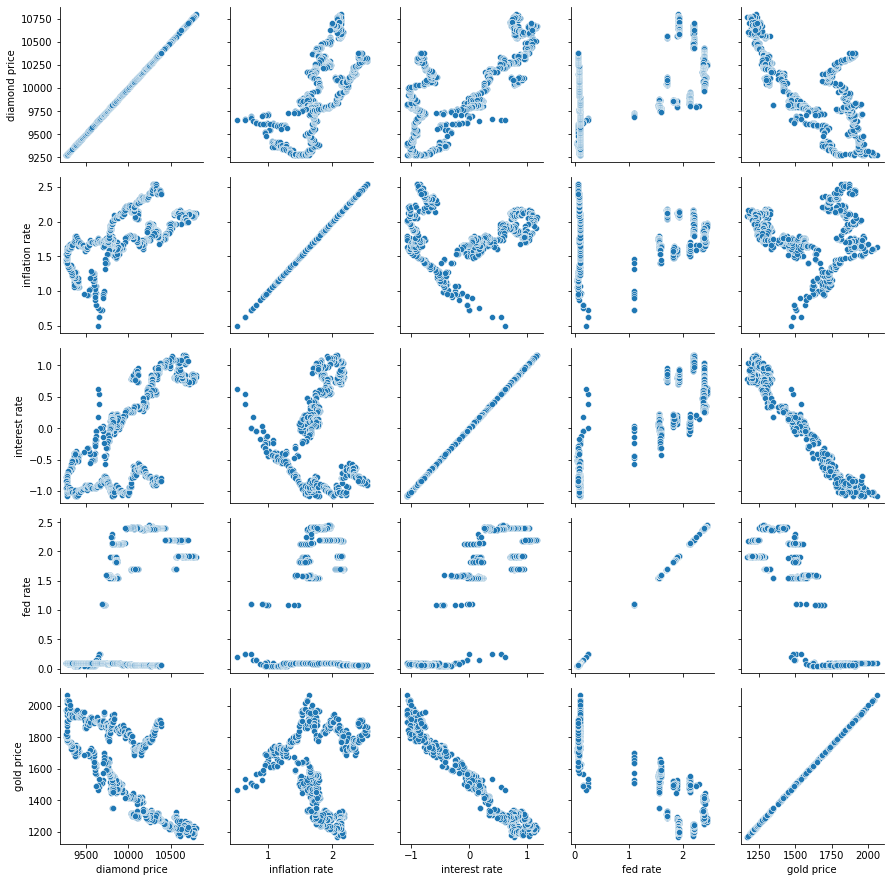

In [8]:
g = sns.PairGrid(diamond)
g.map(sns.scatterplot)
g.savefig("scatter_diamond.png")

In [16]:
## Lagging
train,valid=Split_Part(train_df,0.7)
x_train,y_train = segment(train,'diamond price_1')
x_valid,y_valid = segment(valid,'diamond price_1')

In [17]:
X_arr = x_train.values

### Construct Corr Matrix 

In [18]:
x_mat = np.zeros([x_train_L.shape[1],x_train_L.shape[1]])
feature_num = x_train_no.shape[1]
max_lag = 30

for i in range(0,feature_num):
    ## For each feature,we computew its corr with its self and other features
    ## Self Correlation
    row_start = max_lag*i
    col_end = max_lag*(i+1)
    print(row_start,col_end)
    x_mat[row_start,row_start+1:col_end] = [stats.pearsonr(X_arr[:,row_start],X_arr[:,p])[0] for p in range(max_lag*i+1,max_lag*(i+1))]
    ## Diagnal
    for k in range(row_start+1,col_end-1):
        for j in range(row_start,max_lag*(i+1)-(k-max_lag*i)):
            x_mat[j,j+(k-max_lag*i)] = x_mat[row_start,k]
            
    ## Between Features
    for row in range(col_end,X_arr.shape[1]):
        for col in range(row_start,col_end):
            x_mat[col][row] = stats.pearsonr(X_arr[:,row],X_arr[:,col])[0]

0 30
30 60
60 90
90 120
120 150


In [19]:
corr_copy = x_mat.copy()
corr_copy = np.abs(corr_copy)

In [20]:
def flat(nums):
    res = []
    for i in nums:
        if isinstance(i, list):
            res.extend(flat(i))
        else:
            res.append(i)
    return res

In [22]:
def generate_feature_subsets(corr_matrix,threshold):
    
    correlation_pairs = np.argwhere(corr_matrix>=threshold)
    
    # Check how many features are highly correlated with 1 feature
    correlated_pairs_dict = {}

    for i in set(correlation_pairs[:,0]):
        correlated_pairs_dict[i] = []
        for j in correlation_pairs:
            if j[0]==i:
                correlated_pairs_dict[i].append(j[1])
                
    high_correlated_features = list(set(correlation_pairs.flatten()))
    print("High_correlated_features",len(high_correlated_features))
    corr_cols = x_train_L.columns[high_correlated_features]
    # Use Mutual Information Regression to rank those highly redundent features
    max_feats = len(corr_cols)
    sel_function = mutual_info_regression
    fs = SelectKBest(score_func=sel_function, k=max_feats)
    fs.fit(x_train[corr_cols],y_train)
    mutual_info = dict(zip(high_correlated_features,fs.scores_))
    sorted_by_mutual_info =[key for (key,val) in sorted(mutual_info.items(), key=lambda kv: kv[1],reverse=True)]
    
    check_corr_pairs = {}
    kk = list(correlated_pairs_dict.keys())
    kk_copy = kk.copy()
    for j in kk_copy:
        check_corr_pairs[j] = correlated_pairs_dict[j].copy()
        for i in correlated_pairs_dict[j]:
            if i in kk:
                check_corr_pairs[j].append(correlated_pairs_dict[i])
                for q in correlated_pairs_dict[i]:
                    if q in kk_copy:
                        kk_copy.remove(q)
            if i in kk_copy:
                    kk_copy.remove(i)
        check_corr_pairs[j] = list(set(flat(check_corr_pairs[j])))
        
    redundant_group = []

    for k,v in check_corr_pairs.items():
        redundant_group.append([k]+v)
    
    mrmr_features = []
    for i in redundant_group:
        indexes = [sorted_by_mutual_info.index(j) for j in i]
        mrmr_features.append(sorted_by_mutual_info[min(indexes)])
    print("MRMR Features",len(mrmr_features))
    
    
    ## Uncorelated features
    lst = []
    for i in range(x_train.shape[1]):
        if i not in high_correlated_features:
            lst.append(i)
    ## Joint filtered features with uncorrelated pairs
    final_list = list(set(mrmr_features+lst))
    
    print("Final Features:",len(final_list))
    return final_list

In [26]:
feature_collections = {}
for i in :
    print(i)
    feature_collections[i] = list(x_train.columns[generate_feature_subsets(corr_copy,i)])

0.85
High_correlated_features 150
MRMR Features 2
Final Features: 2
0.86
High_correlated_features 150
MRMR Features 2
Final Features: 2
0.87
High_correlated_features 150
MRMR Features 3
Final Features: 3
0.88
High_correlated_features 150
MRMR Features 3
Final Features: 3
0.89
High_correlated_features 150
MRMR Features 3
Final Features: 3
0.9
High_correlated_features 150
MRMR Features 3
Final Features: 3
0.91
High_correlated_features 150
MRMR Features 4
Final Features: 4
0.92
High_correlated_features 150
MRMR Features 5
Final Features: 5
0.93
High_correlated_features 150
MRMR Features 5
Final Features: 5
0.94
High_correlated_features 150
MRMR Features 7
Final Features: 7
0.95
High_correlated_features 150
MRMR Features 8
Final Features: 8
0.96
High_correlated_features 150
MRMR Features 9
Final Features: 9
0.97
High_correlated_features 150
MRMR Features 13
Final Features: 13
0.98
High_correlated_features 150
MRMR Features 19
Final Features: 19
0.99
High_correlated_features 150
MRMR Featur

In [27]:
feature_nums = {}
for k,v in feature_collections.items():
    feature_nums[k] = len(v)

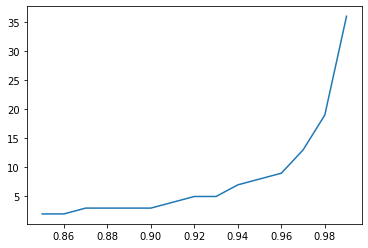

In [28]:
plt.plot(pd.Series(feature_nums))

In [47]:
import copy

In [50]:
def join_err(err):
    error_dict = copy.deepcopy(err)
    for k,v in error_dict.items():
        pd.MultiIndex.from_product([[k],v.columns])
        v.columns = pd.MultiIndex.from_product([ [k],v.columns ])
    err_df = pd.concat([error_dict[k] for k in error_dict.keys()],axis=1)
    print("Min",np.nanmin(err_df.loc[:,pd.IndexSlice[:,'rmse']].values))
    return err_df

### XGBoost
### LightBGM
### RandomForest

### DataSets

Dow Jones Data

Electricity Data

Diamond Data

Air Quality

In [29]:
def lgb_pipeline(X_train,Y_train,X_test,Y_test,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test = minmax_y_test.fit_transform(Y_test.values.reshape(-1,1))
    
    gbm = lgb.LGBMRegressor()
    gbm.fit(x_train, y_train,eval_set = [(x_test,y_test)],early_stopping_rounds = 10)

    features = X_train.columns
    importances = gbm.feature_importances_
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = features
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
    
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
#     plt.title('Top 10 features with LightBGM model')
#     plt.show()
    
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    return top_features

In [30]:
def rfr_pipeline(X_train,Y_train,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    
    
    rfr = RandomForestRegressor()
    rfr.fit(x_train,y_train.reshape(-1,))
    
    feature_names = X_train.columns
    importances = rfr.feature_importances_
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = feature_names
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
#     plt.title('Top 10 features with Random Forest model')
#     plt.show()
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    
    return top_features

In [31]:
def xgb_pipeline(X_train,Y_train,X_test,Y_test,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test = minmax_y_test.fit_transform(Y_test.values.reshape(-1,1))
    
    xgb = XGBRegressor()
    xgb.fit(x_train,y_train.reshape(-1,),eval_set=[(x_test, y_test)],early_stopping_rounds=10)

    feature_names = X_train.columns
    importances = xgb.feature_importances_
#     plot_importance(xgb,max_num_features=10,importance_type='gain',show_values=False)
    
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = feature_names
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
# #     plt.barh(importances_df['Feature_Name'][:10], importances_df['Feature_Importance'][:10]) 
#     plt.title('Top 10 features with XGB model')
#     plt.show()
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    return top_features

In [32]:
def rfr_recursive(cols,feature_num_1,feature_num_2):
    
    max_end = int(0.2*len(cols))
    
    range_end = 0
    
    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                rfr_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    rfr_features.append( rfr_pipeline(x_train_L[now_cols],y_train_L,j))
                rfr_features = list(set(np.array(rfr_features).flatten()))
                features_dict[j] = rfr_features
                print(j,end='\r',flush=True)
                
            return features_dict
        
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
        
        features_dict = {}
        for j in range(feature_num_1,range_end+1):
            rfr_features = []
            for i in range(5):
                col_len = int(len(cols)*i*0.2)
                now_cols = cols[col_len:]
                rfr_features.append( rfr_pipeline(x_train_L[now_cols],y_train_L,j))

            rfr_features = list(set(np.array(rfr_features).flatten()))
            features_dict[j] = rfr_features
        
            print(j,end='\r',flush=True)
        return features_dict

In [33]:
def lgb_recursive(cols,feature_num_1,feature_num_2):
    
    max_end = int(0.2*len(cols))
    range_end = 0

    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                lgb_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    lgb_features.append( lgb_pipeline(x_train[now_cols],y_train,x_valid[now_cols],y_valid,j))

                lgb_features = list(set(np.array(lgb_features).flatten()))
                features_dict[j] = lgb_features
                print(j,end='\r',flush=True)
            return features_dict
        
    features_dict = {}
    
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
    
    for j in range(feature_num_1,range_end+1):
        lgb_features = []
        for i in range(5):
            col_len = int(len(cols)*i*0.2)
            now_cols = cols[col_len:]
            lgb_features.append(lgb_pipeline(x_train[now_cols],y_train,x_valid[now_cols],y_valid,j))
        lgb_features = list(set(np.array(lgb_features).flatten()))
        features_dict[j] = lgb_features
        print(j,end='\r',flush=True)
    return features_dict

In [34]:
def xgb_recursive(cols,feature_num_1,feature_num_2):
    
    max_end = int(0.2*len(cols))
    range_end = 0
    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                xgb_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    xgb_features.append( xgb_pipeline(x_train[now_cols],y_train,x_valid[now_cols],y_valid,j))
                xgb_features = list(set(np.array(xgb_features).flatten()))
                features_dict[j] = xgb_features
                print(j,end='\r',flush=True)
            return features_dict
        

        
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
        
    features_dict = {}
    for j in range(feature_num_1,range_end +1):
        xgb_features = []
        for i in range(5):
            col_len = int(len(cols)*i*0.2)
            now_cols = cols[col_len:]
            xgb_features.append( xgb_pipeline(x_train[now_cols],y_train,x_valid[now_cols],y_valid,j))
        xgb_features = list(set(np.array(xgb_features).flatten()))
        features_dict[j] = xgb_features
        print(j,end='\r',flush=True)
    return features_dict

In [35]:
real_lgb = {}
for k,v in feature_collections.items():
    print(k)
    real_lgb[k] = lgb_recursive(v,1,5)

0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
[1]	valid_0's l2: 0.088118
[2]	valid_0's l2: 0.0716725
[3]	valid_0's l2: 0.0585719
[4]	valid_0's l2: 0.0474662
[5]	valid_0's l2: 0.038669
[6]	valid_0's l2: 0.0318465
[7]	valid_0's l2: 0.0261184
[8]	valid_0's l2: 0.0213638
[9]	valid_0's l2: 0.017386
[10]	valid_0's l2: 0.014329
[11]	valid_0's l2: 0.0118558
[12]	valid_0's l2: 0.00966576
[13]	valid_0's l2: 0.00796444
[14]	valid_0's l2: 0.00655688
[15]	valid_0's l2: 0.0054849
[16]	valid_0's l2: 0.00455699
[17]	valid_0's l2: 0.00382635
[18]	valid_0's l2: 0.00325129
[19]	valid_0's l2: 0.00271119
[20]	valid_0's l2: 0.00226647
[21]	valid_0's l2: 0.00192079
[22]	valid_0's l2: 0.0016307
[23]	valid_0's l2: 0.0013952
[24]	valid_0's l2: 0.00119914
[25]	valid_0's l2: 0.00104024
[26]	valid_0's l2: 0.000913183
[27]	valid_0's l2: 0.000808319
[28]	valid_0's l2: 0.00072182
[29]	valid_0's l2: 0.000652225
[30]	valid_0's l2: 0.000598746
[31]	valid_0's l2: 0.000556728
[32]	valid_0's l2: 0.000519572
[33]	valid_0

[56]	valid_0's l2: 0.0175679
[57]	valid_0's l2: 0.0175747
[58]	valid_0's l2: 0.0174679
[59]	valid_0's l2: 0.0173679
[60]	valid_0's l2: 0.0173928
[61]	valid_0's l2: 0.0173762
[62]	valid_0's l2: 0.0172501
[63]	valid_0's l2: 0.0172835
[64]	valid_0's l2: 0.0171959
[65]	valid_0's l2: 0.017184
[66]	valid_0's l2: 0.0172145
[67]	valid_0's l2: 0.0172052
[68]	valid_0's l2: 0.0171692
[69]	valid_0's l2: 0.0171825
[70]	valid_0's l2: 0.0172041
[71]	valid_0's l2: 0.0170921
[72]	valid_0's l2: 0.0170898
[73]	valid_0's l2: 0.0170317
[74]	valid_0's l2: 0.0170637
[75]	valid_0's l2: 0.0170324
[76]	valid_0's l2: 0.0170436
[77]	valid_0's l2: 0.0170256
[78]	valid_0's l2: 0.0170503
[79]	valid_0's l2: 0.0169363
[80]	valid_0's l2: 0.0169101
[81]	valid_0's l2: 0.0168607
[82]	valid_0's l2: 0.0168429
[83]	valid_0's l2: 0.0168479
[84]	valid_0's l2: 0.0167536
[85]	valid_0's l2: 0.0167351
[86]	valid_0's l2: 0.0167391
[87]	valid_0's l2: 0.0167571
[88]	valid_0's l2: 0.0167767
[89]	valid_0's l2: 0.0167366
[90]	valid_0's 

[61]	valid_0's l2: 0.0179812
[62]	valid_0's l2: 0.0179556
[63]	valid_0's l2: 0.0179079
[64]	valid_0's l2: 0.017902
[65]	valid_0's l2: 0.0179275
[66]	valid_0's l2: 0.0178928
[67]	valid_0's l2: 0.0178788
[68]	valid_0's l2: 0.017907
[69]	valid_0's l2: 0.0179006
[70]	valid_0's l2: 0.0178977
[71]	valid_0's l2: 0.0178818
[72]	valid_0's l2: 0.0179216
[73]	valid_0's l2: 0.017887
[74]	valid_0's l2: 0.0179027
[75]	valid_0's l2: 0.0178221
[76]	valid_0's l2: 0.0177831
[77]	valid_0's l2: 0.0177743
[78]	valid_0's l2: 0.0177101
[79]	valid_0's l2: 0.0177058
[80]	valid_0's l2: 0.0177051
[81]	valid_0's l2: 0.0176457
[82]	valid_0's l2: 0.0175968
[83]	valid_0's l2: 0.0175829
[84]	valid_0's l2: 0.0175319
[85]	valid_0's l2: 0.0174262
[86]	valid_0's l2: 0.0174281
[87]	valid_0's l2: 0.0173328
[88]	valid_0's l2: 0.0173149
[89]	valid_0's l2: 0.0173097
[90]	valid_0's l2: 0.0172785
[91]	valid_0's l2: 0.0172229
[92]	valid_0's l2: 0.0171995
[93]	valid_0's l2: 0.0172127
[94]	valid_0's l2: 0.0171259
[95]	valid_0's l2

[1]	valid_0's l2: 0.0881157
[2]	valid_0's l2: 0.0713125
[3]	valid_0's l2: 0.0582033
[4]	valid_0's l2: 0.0471294
[5]	valid_0's l2: 0.0380367
[6]	valid_0's l2: 0.0309239
[7]	valid_0's l2: 0.025231
[8]	valid_0's l2: 0.0203369
[9]	valid_0's l2: 0.0165657
[10]	valid_0's l2: 0.0133794
[11]	valid_0's l2: 0.0109731
[12]	valid_0's l2: 0.00891764
[13]	valid_0's l2: 0.00732553
[14]	valid_0's l2: 0.00605516
[15]	valid_0's l2: 0.00506212
[16]	valid_0's l2: 0.00424053
[17]	valid_0's l2: 0.00360065
[18]	valid_0's l2: 0.00296925
[19]	valid_0's l2: 0.00250173
[20]	valid_0's l2: 0.00212657
[21]	valid_0's l2: 0.00182565
[22]	valid_0's l2: 0.00161737
[23]	valid_0's l2: 0.0014587
[24]	valid_0's l2: 0.00132316
[25]	valid_0's l2: 0.00123225
[26]	valid_0's l2: 0.00116552
[27]	valid_0's l2: 0.00110073
[28]	valid_0's l2: 0.00105588
[29]	valid_0's l2: 0.00102552
[30]	valid_0's l2: 0.00100437
[31]	valid_0's l2: 0.000983128
[32]	valid_0's l2: 0.000976784
[33]	valid_0's l2: 0.000957738
[34]	valid_0's l2: 0.00095162

[30]	valid_0's l2: 0.00723105
[31]	valid_0's l2: 0.00725207
[32]	valid_0's l2: 0.00721654
[33]	valid_0's l2: 0.00721777
[34]	valid_0's l2: 0.00716948
[35]	valid_0's l2: 0.00718644
[36]	valid_0's l2: 0.00720495
[37]	valid_0's l2: 0.00715329
[38]	valid_0's l2: 0.00719452
[39]	valid_0's l2: 0.00722366
[40]	valid_0's l2: 0.0072343
[41]	valid_0's l2: 0.00729272
[42]	valid_0's l2: 0.00727124
[43]	valid_0's l2: 0.00723203
[44]	valid_0's l2: 0.00724692
[45]	valid_0's l2: 0.00731978
[46]	valid_0's l2: 0.00728566
[47]	valid_0's l2: 0.00726549
[1]	valid_0's l2: 0.0914948
[2]	valid_0's l2: 0.0773985
[3]	valid_0's l2: 0.0647936
[4]	valid_0's l2: 0.055541
[5]	valid_0's l2: 0.047695
[6]	valid_0's l2: 0.0433428
[7]	valid_0's l2: 0.0384295
[8]	valid_0's l2: 0.0337927
[9]	valid_0's l2: 0.0302842
[10]	valid_0's l2: 0.0275718
[11]	valid_0's l2: 0.0260044
[12]	valid_0's l2: 0.0245014
[13]	valid_0's l2: 0.0232774
[14]	valid_0's l2: 0.0216564
[15]	valid_0's l2: 0.0208573
[16]	valid_0's l2: 0.019917
[17]	vali

[2]	valid_0's l2: 0.0792738
[3]	valid_0's l2: 0.0688404
[4]	valid_0's l2: 0.0605236
[5]	valid_0's l2: 0.0535591
[6]	valid_0's l2: 0.0463013
[7]	valid_0's l2: 0.0404276
[8]	valid_0's l2: 0.0356882
[9]	valid_0's l2: 0.0338748
[10]	valid_0's l2: 0.0303399
[11]	valid_0's l2: 0.0294976
[12]	valid_0's l2: 0.027458
[13]	valid_0's l2: 0.0255406
[14]	valid_0's l2: 0.0244795
[15]	valid_0's l2: 0.023519
[16]	valid_0's l2: 0.0228516
[17]	valid_0's l2: 0.0223321
[18]	valid_0's l2: 0.0220407
[19]	valid_0's l2: 0.0206592
[20]	valid_0's l2: 0.0195946
[21]	valid_0's l2: 0.0187958
[22]	valid_0's l2: 0.0181816
[23]	valid_0's l2: 0.0176614
[24]	valid_0's l2: 0.0171945
[25]	valid_0's l2: 0.0165399
[26]	valid_0's l2: 0.0160409
[27]	valid_0's l2: 0.0155388
[28]	valid_0's l2: 0.0151651
[29]	valid_0's l2: 0.0148492
[30]	valid_0's l2: 0.0146395
[31]	valid_0's l2: 0.0144558
[32]	valid_0's l2: 0.0141808
[33]	valid_0's l2: 0.0140559
[34]	valid_0's l2: 0.0138705
[35]	valid_0's l2: 0.0136315
[36]	valid_0's l2: 0.013

0.99
[1]	valid_0's l2: 0.0880542
[2]	valid_0's l2: 0.0726435
[3]	valid_0's l2: 0.0589919
[4]	valid_0's l2: 0.0481392
[5]	valid_0's l2: 0.0391048
[6]	valid_0's l2: 0.0320416
[7]	valid_0's l2: 0.0260668
[8]	valid_0's l2: 0.0214607
[9]	valid_0's l2: 0.017446
[10]	valid_0's l2: 0.0145252
[11]	valid_0's l2: 0.0118978
[12]	valid_0's l2: 0.00986271
[13]	valid_0's l2: 0.00821249
[14]	valid_0's l2: 0.00685916
[15]	valid_0's l2: 0.00572653
[16]	valid_0's l2: 0.00488084
[17]	valid_0's l2: 0.00414178
[18]	valid_0's l2: 0.00357729
[19]	valid_0's l2: 0.0031546
[20]	valid_0's l2: 0.00286672
[21]	valid_0's l2: 0.00260813
[22]	valid_0's l2: 0.00236153
[23]	valid_0's l2: 0.00221404
[24]	valid_0's l2: 0.00212647
[25]	valid_0's l2: 0.00200267
[26]	valid_0's l2: 0.00191591
[27]	valid_0's l2: 0.00184011
[28]	valid_0's l2: 0.00177562
[29]	valid_0's l2: 0.00173253
[30]	valid_0's l2: 0.00172039
[31]	valid_0's l2: 0.00172973
[32]	valid_0's l2: 0.00175192
[33]	valid_0's l2: 0.00176061
[34]	valid_0's l2: 0.001774

[2]	valid_0's l2: 0.0979113
[3]	valid_0's l2: 0.0963947
[4]	valid_0's l2: 0.095413
[5]	valid_0's l2: 0.0959583
[6]	valid_0's l2: 0.0966421
[7]	valid_0's l2: 0.0973982
[8]	valid_0's l2: 0.100142
[9]	valid_0's l2: 0.101791
[10]	valid_0's l2: 0.103033
[11]	valid_0's l2: 0.105879
[12]	valid_0's l2: 0.10846
[13]	valid_0's l2: 0.110542
[14]	valid_0's l2: 0.112115
[1]	valid_0's l2: 0.0880542
[2]	valid_0's l2: 0.0726435
[3]	valid_0's l2: 0.0589919
[4]	valid_0's l2: 0.0481392
[5]	valid_0's l2: 0.0391048
[6]	valid_0's l2: 0.0320416
[7]	valid_0's l2: 0.0260668
[8]	valid_0's l2: 0.0214607
[9]	valid_0's l2: 0.017446
[10]	valid_0's l2: 0.0145252
[11]	valid_0's l2: 0.0118978
[12]	valid_0's l2: 0.00986271
[13]	valid_0's l2: 0.00821249
[14]	valid_0's l2: 0.00685916
[15]	valid_0's l2: 0.00572653
[16]	valid_0's l2: 0.00488084
[17]	valid_0's l2: 0.00414178
[18]	valid_0's l2: 0.00357729
[19]	valid_0's l2: 0.0031546
[20]	valid_0's l2: 0.00286672
[21]	valid_0's l2: 0.00260813
[22]	valid_0's l2: 0.00236153
[2

[2]	valid_0's l2: 0.0982062
[3]	valid_0's l2: 0.0978032
[4]	valid_0's l2: 0.0965719
[5]	valid_0's l2: 0.0962407
[6]	valid_0's l2: 0.0968472
[7]	valid_0's l2: 0.0992277
[8]	valid_0's l2: 0.099709
[9]	valid_0's l2: 0.103111
[10]	valid_0's l2: 0.106153
[11]	valid_0's l2: 0.107914
[12]	valid_0's l2: 0.109948
[13]	valid_0's l2: 0.111788
[14]	valid_0's l2: 0.112546
[15]	valid_0's l2: 0.114999
[1]	valid_0's l2: 0.102029
[2]	valid_0's l2: 0.0979113
[3]	valid_0's l2: 0.0963947
[4]	valid_0's l2: 0.095413
[5]	valid_0's l2: 0.0959583
[6]	valid_0's l2: 0.0966421
[7]	valid_0's l2: 0.0973982
[8]	valid_0's l2: 0.100142
[9]	valid_0's l2: 0.101791
[10]	valid_0's l2: 0.103033
[11]	valid_0's l2: 0.105879
[12]	valid_0's l2: 0.10846
[13]	valid_0's l2: 0.110542
[14]	valid_0's l2: 0.112115
[1]	valid_0's l2: 0.0880542
[2]	valid_0's l2: 0.0726435
[3]	valid_0's l2: 0.0589919
[4]	valid_0's l2: 0.0481392
[5]	valid_0's l2: 0.0391048
[6]	valid_0's l2: 0.0320416
[7]	valid_0's l2: 0.0260668
[8]	valid_0's l2: 0.0214607

In [36]:
real_xgb = {}
for k,v in feature_collections.items():
    print(k)
    real_xgb[k] = xgb_recursive(v,1,5)

0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
[0]	validation_0-rmse:0.23269
[1]	validation_0-rmse:0.16695
[2]	validation_0-rmse:0.11979
[3]	validation_0-rmse:0.08531
[4]	validation_0-rmse:0.06171
[5]	validation_0-rmse:0.04659
[6]	validation_0-rmse:0.03582
[7]	validation_0-rmse:0.03037
[8]	validation_0-rmse:0.02715
[9]	validation_0-rmse:0.02397
[10]	validation_0-rmse:0.02332
[11]	validation_0-rmse:0.02131
[12]	validation_0-rmse:0.02055
[13]	validation_0-rmse:0.02019
[14]	validation_0-rmse:0.02008
[15]	validation_0-rmse:0.02006
[16]	validation_0-rmse:0.02024
[17]	validation_0-rmse:0.02023
[18]	validation_0-rmse:0.02001
[19]	validation_0-rmse:0.02007
[20]	validation_0-rmse:0.02004
[21]	validation_0-rmse:0.01988
[22]	validation_0-rmse:0.01989
[23]	validation_0-rmse:0.01988
[24]	validation_0-rmse:0.01982
[25]	validation_0-rmse:0.01982
[26]	validation_0-rmse:0.01985
[27]	validation_0-rmse:0.01985
[28]	validation_0-rmse:0.01982
[29]	validation_0-rmse:0.01983
[30]	validation_0-rmse:0.01980


[13]	validation_0-rmse:0.22809
[14]	validation_0-rmse:0.22901
[15]	validation_0-rmse:0.23001
0.96
[0]	validation_0-rmse:0.23278
[1]	validation_0-rmse:0.16706
[2]	validation_0-rmse:0.11993
[3]	validation_0-rmse:0.08547
[4]	validation_0-rmse:0.06868
[5]	validation_0-rmse:0.05201
[6]	validation_0-rmse:0.04103
[7]	validation_0-rmse:0.03376
[8]	validation_0-rmse:0.02853
[9]	validation_0-rmse:0.02559
[10]	validation_0-rmse:0.02501
[11]	validation_0-rmse:0.02480
[12]	validation_0-rmse:0.02464
[13]	validation_0-rmse:0.02466
[14]	validation_0-rmse:0.02366
[15]	validation_0-rmse:0.02347
[16]	validation_0-rmse:0.02330
[17]	validation_0-rmse:0.02291
[18]	validation_0-rmse:0.02273
[19]	validation_0-rmse:0.02257
[20]	validation_0-rmse:0.02244
[21]	validation_0-rmse:0.02249
[22]	validation_0-rmse:0.02249
[23]	validation_0-rmse:0.02251
[24]	validation_0-rmse:0.02250
[25]	validation_0-rmse:0.02243
[26]	validation_0-rmse:0.02235
[27]	validation_0-rmse:0.02225
[28]	validation_0-rmse:0.02230
[29]	validati

[16]	validation_0-rmse:0.08682
[17]	validation_0-rmse:0.08690
[18]	validation_0-rmse:0.08719
[19]	validation_0-rmse:0.08730
[20]	validation_0-rmse:0.08739
[21]	validation_0-rmse:0.08724
[22]	validation_0-rmse:0.08741
[23]	validation_0-rmse:0.08741
[24]	validation_0-rmse:0.08747
[0]	validation_0-rmse:0.23079
[1]	validation_0-rmse:0.16819
[2]	validation_0-rmse:0.12533
[3]	validation_0-rmse:0.10669
[4]	validation_0-rmse:0.09604
[5]	validation_0-rmse:0.09083
[6]	validation_0-rmse:0.08941
[7]	validation_0-rmse:0.09008
[8]	validation_0-rmse:0.09065
[9]	validation_0-rmse:0.09115
[10]	validation_0-rmse:0.09236
[11]	validation_0-rmse:0.09294
[12]	validation_0-rmse:0.09418
[13]	validation_0-rmse:0.09413
[14]	validation_0-rmse:0.09512
[15]	validation_0-rmse:0.09603
[0]	validation_0-rmse:0.23281
[1]	validation_0-rmse:0.16705
[2]	validation_0-rmse:0.11983
[3]	validation_0-rmse:0.09766
[4]	validation_0-rmse:0.07453
[5]	validation_0-rmse:0.06405
[6]	validation_0-rmse:0.05524
[7]	validation_0-rmse:0.0

[6]	validation_0-rmse:0.09172
[7]	validation_0-rmse:0.09008
[8]	validation_0-rmse:0.09064
[9]	validation_0-rmse:0.08859
[10]	validation_0-rmse:0.08732
[11]	validation_0-rmse:0.08717
[12]	validation_0-rmse:0.08704
[13]	validation_0-rmse:0.08679
[14]	validation_0-rmse:0.08656
[15]	validation_0-rmse:0.08611
[16]	validation_0-rmse:0.08571
[17]	validation_0-rmse:0.08548
[18]	validation_0-rmse:0.08515
[19]	validation_0-rmse:0.08507
[20]	validation_0-rmse:0.08509
[21]	validation_0-rmse:0.08512
[22]	validation_0-rmse:0.08513
[23]	validation_0-rmse:0.08510
[24]	validation_0-rmse:0.08525
[25]	validation_0-rmse:0.08523
[26]	validation_0-rmse:0.08508
[27]	validation_0-rmse:0.08505
[28]	validation_0-rmse:0.08491
[29]	validation_0-rmse:0.08490
[30]	validation_0-rmse:0.08487
[31]	validation_0-rmse:0.08422
[32]	validation_0-rmse:0.08397
[33]	validation_0-rmse:0.08417
[34]	validation_0-rmse:0.08422
[35]	validation_0-rmse:0.08424
[36]	validation_0-rmse:0.08414
[37]	validation_0-rmse:0.08423
[38]	validat

[4]	validation_0-rmse:0.10717
[5]	validation_0-rmse:0.10058
[6]	validation_0-rmse:0.09443
[7]	validation_0-rmse:0.09288
[8]	validation_0-rmse:0.09242
[9]	validation_0-rmse:0.09171
[10]	validation_0-rmse:0.09126
[11]	validation_0-rmse:0.09084
[12]	validation_0-rmse:0.09090
[13]	validation_0-rmse:0.09055
[14]	validation_0-rmse:0.08958
[15]	validation_0-rmse:0.08973
[16]	validation_0-rmse:0.08909
[17]	validation_0-rmse:0.08849
[18]	validation_0-rmse:0.08862
[19]	validation_0-rmse:0.08829
[20]	validation_0-rmse:0.08817
[21]	validation_0-rmse:0.08818
[22]	validation_0-rmse:0.08824
[23]	validation_0-rmse:0.08844
[24]	validation_0-rmse:0.08848
[25]	validation_0-rmse:0.08822
[26]	validation_0-rmse:0.08819
[27]	validation_0-rmse:0.08819
[28]	validation_0-rmse:0.08819
[29]	validation_0-rmse:0.08821
[30]	validation_0-rmse:0.08821
[0]	validation_0-rmse:0.24365
[1]	validation_0-rmse:0.17333
[2]	validation_0-rmse:0.14468
[3]	validation_0-rmse:0.11613
[4]	validation_0-rmse:0.10882
[5]	validation_0-rm

[35]	validation_0-rmse:0.13004
[36]	validation_0-rmse:0.13002
[37]	validation_0-rmse:0.13003
[38]	validation_0-rmse:0.13004
[39]	validation_0-rmse:0.13004
[40]	validation_0-rmse:0.13009
[41]	validation_0-rmse:0.13010
[42]	validation_0-rmse:0.12997
[43]	validation_0-rmse:0.12988
[44]	validation_0-rmse:0.12991
[45]	validation_0-rmse:0.12992
[46]	validation_0-rmse:0.12992
[47]	validation_0-rmse:0.12990
[48]	validation_0-rmse:0.12993
[49]	validation_0-rmse:0.12993
[50]	validation_0-rmse:0.12974
[51]	validation_0-rmse:0.12977
[52]	validation_0-rmse:0.12977
[53]	validation_0-rmse:0.12977
[54]	validation_0-rmse:0.12977
[55]	validation_0-rmse:0.12977
[56]	validation_0-rmse:0.12977
[57]	validation_0-rmse:0.12977
[58]	validation_0-rmse:0.12977
[59]	validation_0-rmse:0.12977
[0]	validation_0-rmse:0.26751
[1]	validation_0-rmse:0.23333
[2]	validation_0-rmse:0.21750
[3]	validation_0-rmse:0.19917
[4]	validation_0-rmse:0.19068
[5]	validation_0-rmse:0.18976
[6]	validation_0-rmse:0.19094
[7]	validation_

[5]	validation_0-rmse:0.18976
[6]	validation_0-rmse:0.19094
[7]	validation_0-rmse:0.18997
[8]	validation_0-rmse:0.18956
[9]	validation_0-rmse:0.18640
[10]	validation_0-rmse:0.18698
[11]	validation_0-rmse:0.18731
[12]	validation_0-rmse:0.18752
[13]	validation_0-rmse:0.18788
[14]	validation_0-rmse:0.18816
[15]	validation_0-rmse:0.18842
[16]	validation_0-rmse:0.18784
[17]	validation_0-rmse:0.18808
[18]	validation_0-rmse:0.18790
[0]	validation_0-rmse:0.31209
[1]	validation_0-rmse:0.31239
[2]	validation_0-rmse:0.32086
[3]	validation_0-rmse:0.33218
[4]	validation_0-rmse:0.33678
[5]	validation_0-rmse:0.34057
[6]	validation_0-rmse:0.34400
[7]	validation_0-rmse:0.34558
[8]	validation_0-rmse:0.34773
[9]	validation_0-rmse:0.34982
[10]	validation_0-rmse:0.35037
[0]	validation_0-rmse:0.31891
[1]	validation_0-rmse:0.32250
[2]	validation_0-rmse:0.32929
[3]	validation_0-rmse:0.33441
[4]	validation_0-rmse:0.34332
[5]	validation_0-rmse:0.34884
[6]	validation_0-rmse:0.35309
[7]	validation_0-rmse:0.35669


In [37]:
real_rfr = {}
for k,v in feature_collections.items():
    print(k)
    real_rfr[k] = rfr_recursive(v,1,5)

0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


### Mix Models

In [24]:
import random

In [25]:
def mix_recursive(final_cols,feature_num):
    mix_features = []
    for i in range(5):
        col_len = int(len(final_cols)*i*0.2)
        now_cols = final_cols[col_len:]
        rm = random.randint(1,3)
        if rm==1:
            model = xgb_pipeline
        elif rm==2:
            model = rf_pipeline
        else:
            model = lgb_pipeline
        mix_features.append(model(x_train_L[now_cols],y_train_L,feature_num))
    mix_features = np.array(mix_features)
    real_mix = set(mix_features.flatten())
    real_mix = list(real_mix)
    return real_mix

## Prediction Models

In [38]:
def rfr_regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))

    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    rfr = RandomForestRegressor()
    
    rfr.fit(x_train,y_train.reshape(-1,))
    y_rfr = rfr.predict(x_test)
    y_rfr_inverse =minmax_y_test.inverse_transform(y_rfr.reshape((-1,1)))
    
    print(
          "RandomForest_mae:%f"%(mean_absolute_error(y_rfr_inverse, Y_test  ))+"\n",
          "RandomForest_rmse:%f"%(sqrt(mean_squared_error(y_rfr_inverse, Y_test  )))+"\n"
#           "elastic_mse:%f"%(mean_squared_error( y_elastic_inverse, Y_test  )),     
     )
    
    y_df = {
        "Original": Y_test.values,
        'RandomForest_':y_rfr_inverse
    }
    
    error_metrics = {
        "mae":(mean_absolute_error(y_rfr_inverse, Y_test  )),
        "rmse":(sqrt(mean_squared_error(y_rfr_inverse, Y_test  )))
    }
    return error_metrics

In [28]:
rfr_regressor(x_train_L,y_train_L,x_test_L,y_test_L)

RandomForest_mae:109.008535
 RandomForest_rmse:150.992677



{'mae': 109.00853474874157, 'rmse': 150.99267657894413}

In [40]:
rfr_regressor(x_train,y_train,x_test_L,y_test_L)

RandomForest_mae:81.325326
 RandomForest_rmse:109.179485



{'mae': 81.32532630722604, 'rmse': 109.17948486512047}

In [32]:
rfr_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    rfr_lgb_error[k] = []
    if type(v)==list:
        rfr_lgb_error[k].append(rfr_regressor(x_train_L[v],y_train_L,x_test_L[v],y_test_L))
        rfr_lgb_error[k] = pd.DataFrame(rfr_lgb_error[k])
        
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            rfr_lgb_error[k].append(rfr_regressor(x_train_L[vv],y_train_L,x_test_L[vv],y_test_L))
        rfr_lgb_error[k] = pd.DataFrame(rfr_lgb_error[k],index = list(v.keys()))

rfr_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    rfr_xgb_error[k] = []
    if type(v)==list:
        rfr_xgb_error[k].append(rfr_regressor(x_train_L[v],y_train_L,x_test_L[v],y_test_L))
        rfr_xgb_error[k] = pd.DataFrame(rfr_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            rfr_xgb_error[k].append(rfr_regressor(x_train_L[vv],y_train_L,x_test_L[vv],y_test_L))
        rfr_xgb_error[k] = pd.DataFrame(rfr_xgb_error[k],index = list(v.keys()))
    
rfr_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    rfr_rfr_error[k] = []
    if type(v) == list:
        rfr_rfr_error[k].append(rfr_regressor(x_train_L[v],y_train_L,x_test_L[v],y_test_L))
        rfr_rfr_error[k] = pd.DataFrame(rfr_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            rfr_rfr_error[k].append(rfr_regressor(x_train_L[vv],y_train_L,x_test_L[vv],y_test_L))
        rfr_rfr_error[k] = pd.DataFrame(rfr_rfr_error[k],index = list(v.keys()))

0.8
RandomForest_mae:21.574692
 RandomForest_rmse:35.161906

0.805
RandomForest_mae:27.865992
 RandomForest_rmse:49.044361

0.81
RandomForest_mae:25.704381
 RandomForest_rmse:44.288026

0.815
RandomForest_mae:25.814180
 RandomForest_rmse:44.355552

0.82
RandomForest_mae:23.584672
 RandomForest_rmse:39.827700

0.825
RandomForest_mae:23.968404
 RandomForest_rmse:40.280999

0.83
RandomForest_mae:22.930850
 RandomForest_rmse:38.579532

0.835
RandomForest_mae:23.932311
 RandomForest_rmse:39.832459

0.84
RandomForest_mae:19.998381
 RandomForest_rmse:32.806195

0.845
RandomForest_mae:24.688837
 RandomForest_rmse:42.172238

0.85
RandomForest_mae:24.860297
 RandomForest_rmse:42.064518

0.855
RandomForest_mae:22.474900
 RandomForest_rmse:38.741629

0.86
RandomForest_mae:24.223178
 RandomForest_rmse:40.472639

0.865
RandomForest_mae:25.214340
 RandomForest_rmse:43.766738

0.87
RandomForest_mae:19.734399
 RandomForest_rmse:32.346087

0.875
RandomForest_mae:25.475426
 RandomForest_rmse:42.568173

0

RandomForest_mae:41.725858
 RandomForest_rmse:54.102372

0.95
RandomForest_mae:40.162691
 RandomForest_rmse:52.214429

0.955
RandomForest_mae:35.265957
 RandomForest_rmse:48.437872

0.96
RandomForest_mae:33.401894
 RandomForest_rmse:43.483083

0.965
1 3
RandomForest_mae:32.354983
 RandomForest_rmse:56.054041

0.97
1 4
RandomForest_mae:38.583172
 RandomForest_rmse:58.671525

0.975
1 3
RandomForest_mae:31.382549
 RandomForest_rmse:58.939973

2 5
RandomForest_mae:49.057518
 RandomForest_rmse:68.021211

0.98
1 3
RandomForest_mae:36.825912
 RandomForest_rmse:70.247663

2 5
RandomForest_mae:53.617312
 RandomForest_rmse:74.689954

0.985
1 3
RandomForest_mae:35.569518
 RandomForest_rmse:63.919453

2 5
RandomForest_mae:59.648183
 RandomForest_rmse:74.661888

3 8
RandomForest_mae:66.496012
 RandomForest_rmse:84.111238

0.99
1 3
RandomForest_mae:13.233151
 RandomForest_rmse:16.940499

2 6
RandomForest_mae:36.376086
 RandomForest_rmse:54.209687

3 9
RandomForest_mae:64.489150
 RandomForest_rmse:88

In [60]:
def avg_rmse(error_list):
    avg = []
    flat = list(error_list.values())
    for i in flat:
        for j in i['rmse'].values:
            avg.append(j)
    avg_score = np.round(mean(avg),3)
    return avg_score

In [61]:
avg_rfr_lgb = avg_rmse(rfr_lgb_error)
avg_rfr_xgb = avg_rmse(rfr_xgb_error)
avg_rfr_rfr = avg_rmse(rfr_rfr_error)

NameError: name 'rfr_lgb_error' is not defined

In [ ]:
avg_rfr_lgb,avg_rfr_xgb,avg_rfr_rfr

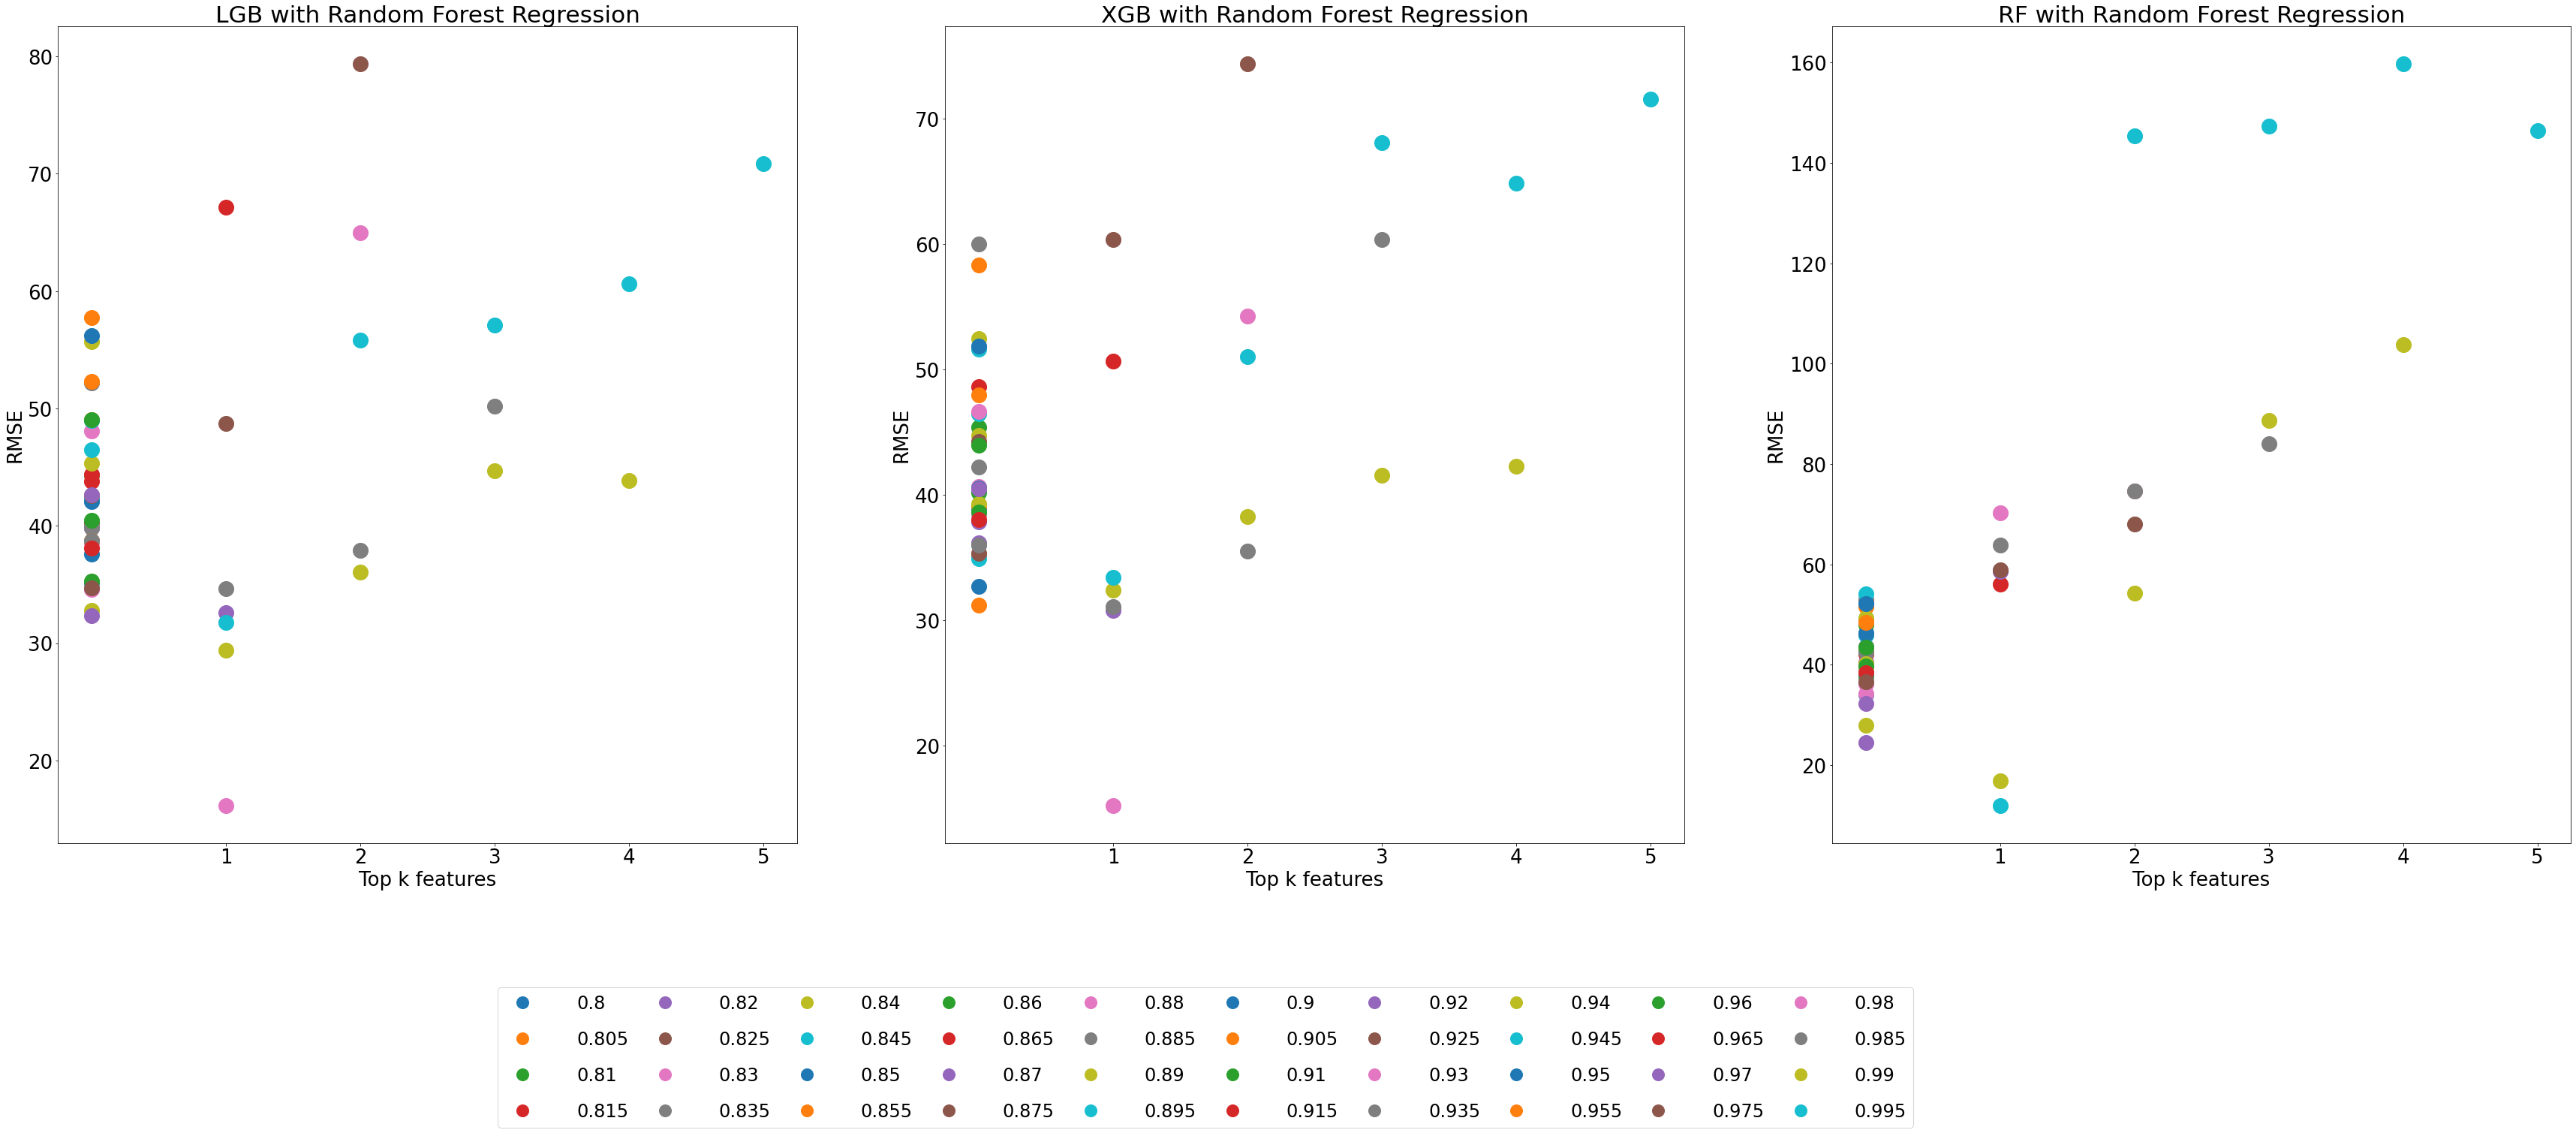

In [43]:
fig,ax = plt.subplots(1,3,figsize=(60,20))

plt.rcParams['font.size'] = '26'

ax[0].set_title("LGB with Random Forest Regression")
for k in rfr_lgb_error .keys():
    ax[0].set_xticks(rfr_lgb_error[k].index)
    ax[0].plot(rfr_lgb_error[k]['rmse'],'o',markersize = 20) 
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("Top k features") 
# ax[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
ax[0].set_visible(True)


ax[1].set_title("XGB with Random Forest Regression")
for k in rfr_xgb_error .keys():
    ax[1].set_xticks(rfr_xgb_error[k].index)
    ax[1].plot(rfr_xgb_error[k]['rmse'],'o',markersize = 20) 
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Top k features") 

ax[2].set_title("RF with Random Forest Regression")
for k in rfr_rfr_error.keys():
    ax[2].set_xticks(rfr_rfr_error[k].index)
    ax[2].plot(rfr_rfr_error[k]['rmse'],'o',markersize = 20)  
ax[2].set_ylabel("RMSE")
ax[2].set_xlabel("Top k features") 

fig.legend(list(rfr_lgb_error.keys()),scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.7, 0),ncol=10,handletextpad=2,fontsize=24)

In [45]:
def Linear_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    reg_Linear =  LinearRegression()
    reg_Linear.fit(x_train,y_train.reshape(-1,))
    y_Linear_a = reg_Linear.predict(x_test)
    y_Linear_a_inverse =minmax_y_test.inverse_transform(y_Linear_a.reshape((-1,1)))
    
    print(
        "rmse: ",sqrt(mean_squared_error(y_Linear_a_inverse,y_test_inverse)),
         "mae:",mean_absolute_error(y_Linear_a_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_Linear_a_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_Linear_a_inverse,y_test_inverse)
    }
    return error_metrics

In [45]:
y_all = Linear_Regressor(x_train_L,y_train_L,x_test_L,y_test_L)

rmse:  18.454208284363826 mae: 15.339138398465547


In [44]:
Linear_Regressor(x_train,y_train,x_test_L,y_test_L)

rmse:  28.931550821858902 mae: 22.86110548376544


{'rmse': 28.931550821858902, 'mae': 22.86110548376544}

In [46]:
li_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    li_lgb_error[k] = []
    if type(v)==list:
        li_lgb_error[k].append(Linear_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        li_lgb_error[k] = pd.DataFrame(li_lgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            li_lgb_error[k].append(Linear_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        li_lgb_error[k] = pd.DataFrame(li_lgb_error[k],index = list(v.keys()))

li_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    li_xgb_error[k] = []
    if type(v)==list:
        li_xgb_error[k].append(Linear_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        li_xgb_error[k] = pd.DataFrame(li_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            li_xgb_error[k].append(Linear_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        li_xgb_error[k] = pd.DataFrame(li_xgb_error[k],index = list(v.keys()))
    
li_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    li_rfr_error[k] = []
    if type(v) == list:
        li_rfr_error[k].append(Linear_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        li_rfr_error[k] = pd.DataFrame(li_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            li_rfr_error[k].append(Linear_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        li_rfr_error[k] = pd.DataFrame(li_rfr_error[k],index = list(v.keys()))

0.85
rmse:  5.85585805058097 mae: 4.701326714617312
0.86
rmse:  5.566614592321551 mae: 4.4248736592552005
0.87
rmse:  13.081399009828393 mae: 11.058111402004242
0.88
rmse:  11.924094654517033 mae: 10.052267952178287
0.89
rmse:  11.924094654517033 mae: 10.052267952178287
0.9
rmse:  11.924094654517033 mae: 10.052267952178287
0.91
rmse:  12.217639782573297 mae: 10.409558759467917
0.92
rmse:  15.604618166597135 mae: 13.71901312779575
0.93
rmse:  15.120105504776584 mae: 13.204214435566252
0.94
1 3
rmse:  7.676982179654538 mae: 6.476924901951396
0.95
1 2
rmse:  5.127372809849598 mae: 4.110873516810268
0.96
1 2
rmse:  5.095492926987526 mae: 4.080981808833751
0.97
1 2
rmse:  5.095492926987526 mae: 4.080981808833751
2 5
rmse:  8.008160246640221 mae: 6.876511608250078
0.98
1 3
rmse:  7.450247622594605 mae: 6.313676223336314
2 8
rmse:  8.972776878848613 mae: 7.7190297318222445
3 10
rmse:  14.110951704992758 mae: 12.274925037029345
0.99
1 5
rmse:  13.05980401571382 mae: 10.707345672672227
2 9
rmse

In [51]:
li_lgb = join_err(li_lgb_error)
li_xgb = join_err(li_xgb_error)
li_rfr = join_err(li_rfr_error)

Min 5.095492926987526
Min 5.566614592321551
Min 5.566614592321551


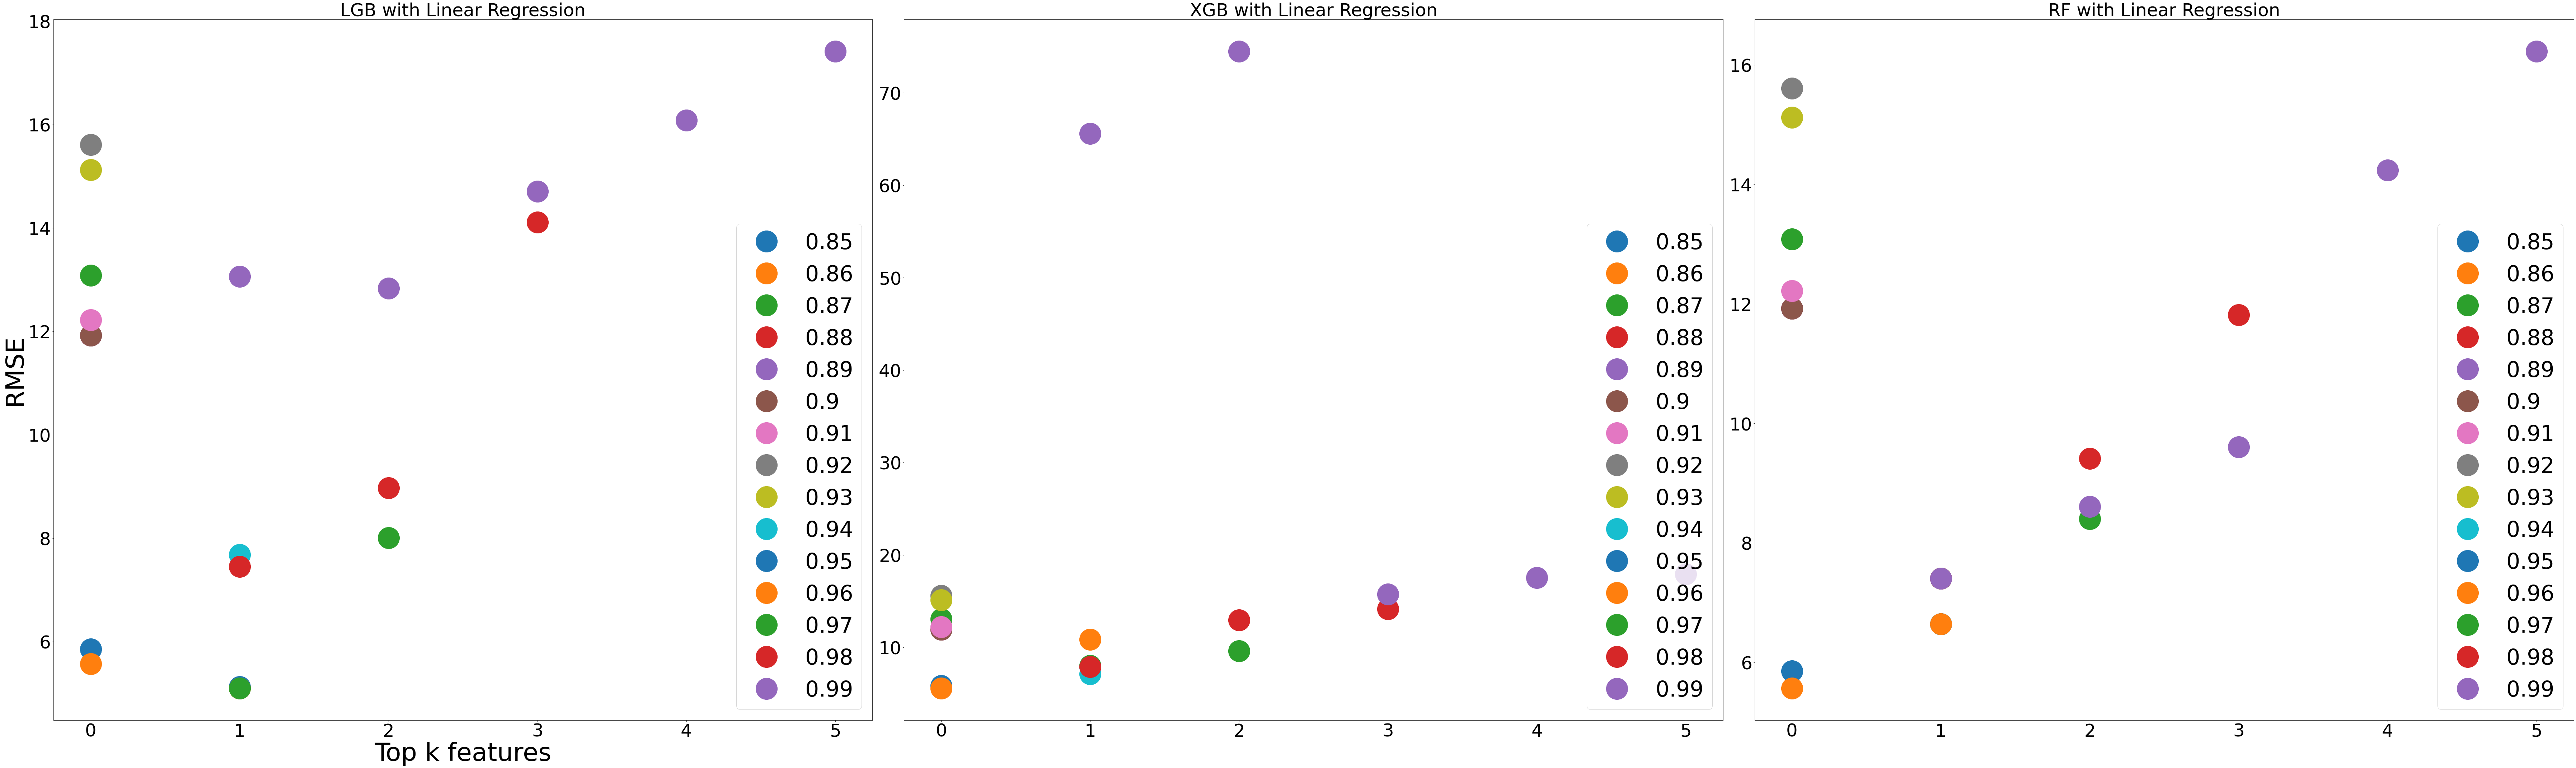

In [77]:
fig,ax = plt.subplots(1,3,figsize=(100,30))
ax[0].set_title("LGB with Linear Regression",fontsize=50)
ax[0].plot(li_lgb.loc[:,pd.IndexSlice[:,'rmse']],'o',markersize = 60)
ax[0].legend(li_lgb.columns.levels[0],fontsize=60,loc='lower right')
ax[0].set_ylabel("RMSE",fontsize=70)
ax[0].set_xlabel("Top k features",fontsize=70)  
ax[0].tick_params(labelsize=50)
ax[1].set_title("XGB with Linear Regression",fontsize=50)
ax[1].plot(li_xgb .loc[:,pd.IndexSlice[:,'rmse']],'o',markersize = 60)
ax[1].legend(li_xgb.columns.levels[0],fontsize=60,loc='lower right')
# ax[1].set_ylabel("RMSE",fontsize=70)
# ax[1].set_xlabel("Top k features",fontsize=70)  
ax[1].tick_params(labelsize=50)
ax[2].set_title("RF with Linear Regression",fontsize=50)
ax[2].plot(li_rfr .loc[:,pd.IndexSlice[:,'rmse']],'o',markersize = 60)
ax[2].legend(li_rfr.columns.levels[0],fontsize=60,loc='lower right')
# ax[2].set_ylabel("RMSE",fontsize=70)
# ax[2].set_xlabel("Top k features",fontsize=70)  
ax[2].tick_params(labelsize=50)

plt.tight_layout()
plt.savefig('linear_diamond.svg')

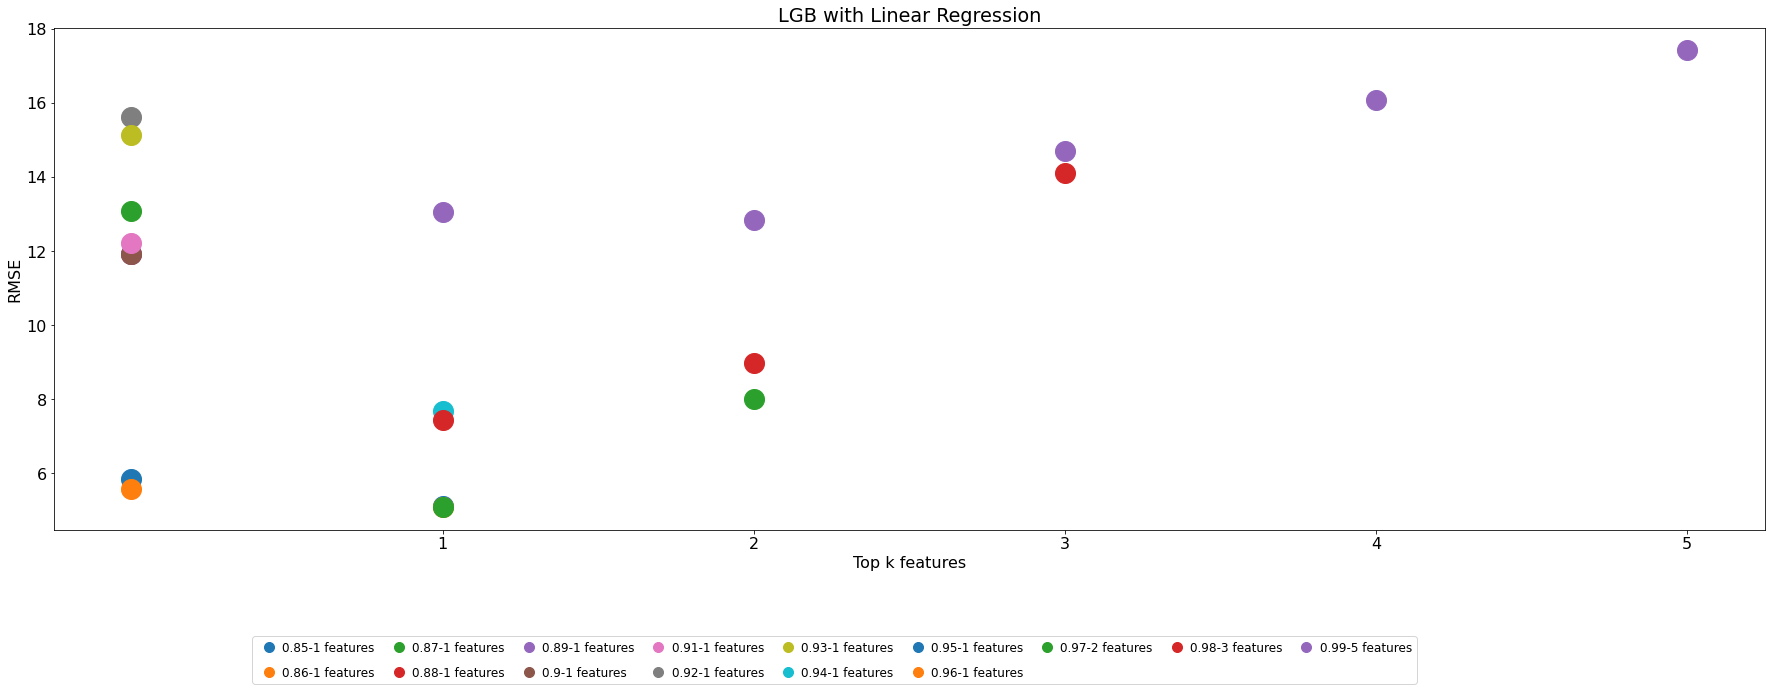

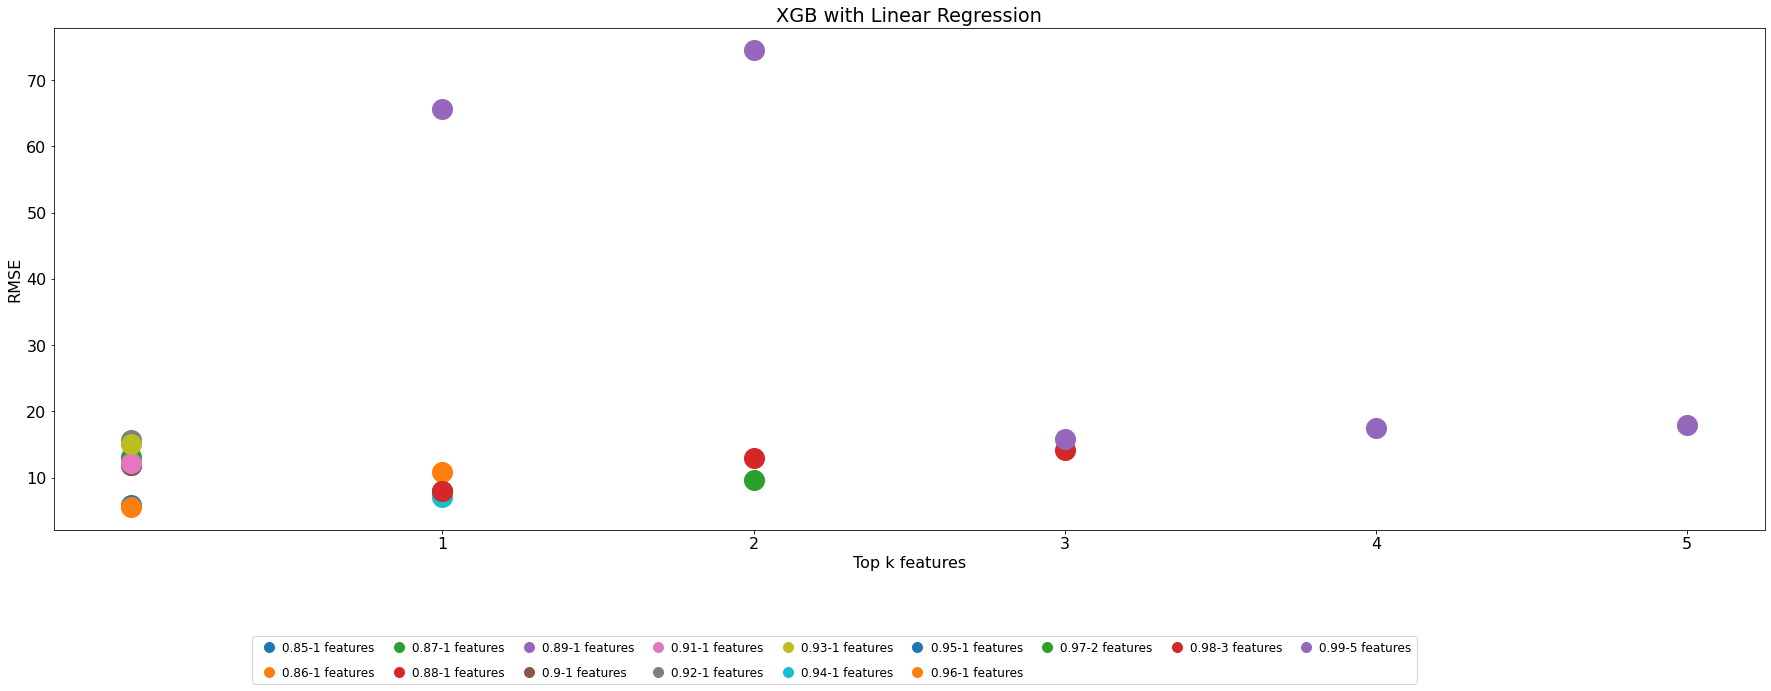

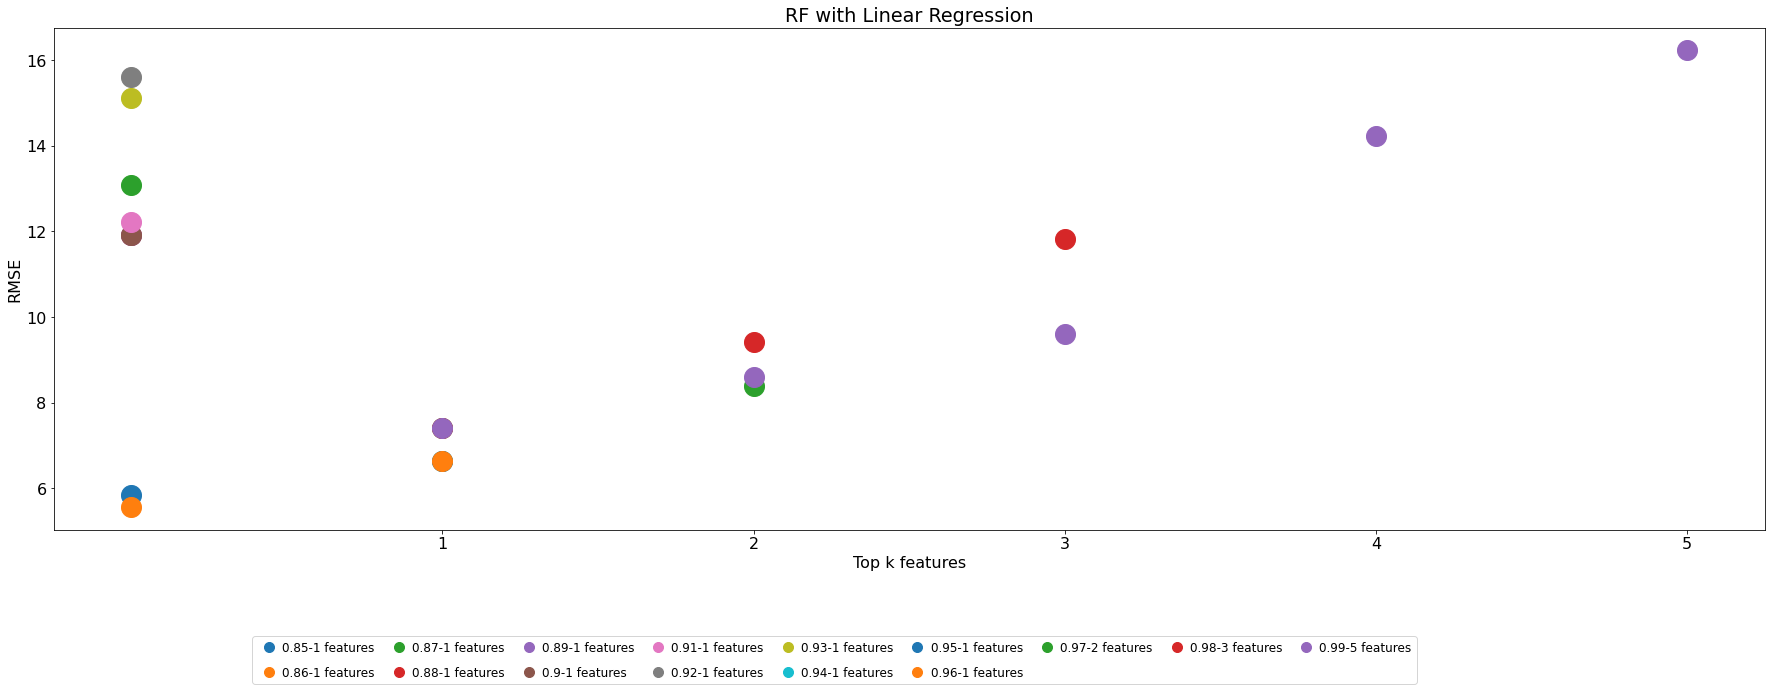

In [71]:
plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = '16'
plt.title("LGB with Linear Regression")
for k in li_lgb_error .keys():
    plt.xticks(li_lgb_error[k].index)
    plt.plot(li_lgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_lgb_error[k]))+' features',markersize = 20) 
plt.ylabel("RMSE")
plt.xlabel("Top k features") 
plt.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(0.8, -0.2),ncol=9,handletextpad=0.1,fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = '16'

plt.title("XGB with Linear Regression")
for k in li_xgb_error .keys():
    plt.xticks(li_xgb_error[k].index)
    plt.plot(li_xgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_lgb_error[k]))+' features',markersize = 20) 
plt.ylabel("RMSE")
plt.xlabel("Top k features") 
plt.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(0.8, -0.2),ncol=9,handletextpad=0.1,fontsize=12)
plt.tight_layout()
plt.show()


plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = '16'

plt.title("RF with Linear Regression")
for k in li_rfr_error.keys():
    plt.xticks(li_rfr_error[k].index)
    plt.plot(li_rfr_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_rfr_error[k]))+' features',markersize = 20)  
plt.ylabel("RMSE")
plt.xlabel("Top k features") 
plt.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(0.8, -0.2),ncol=9,handletextpad=0.1,fontsize=12)
plt.tight_layout()
plt.show()

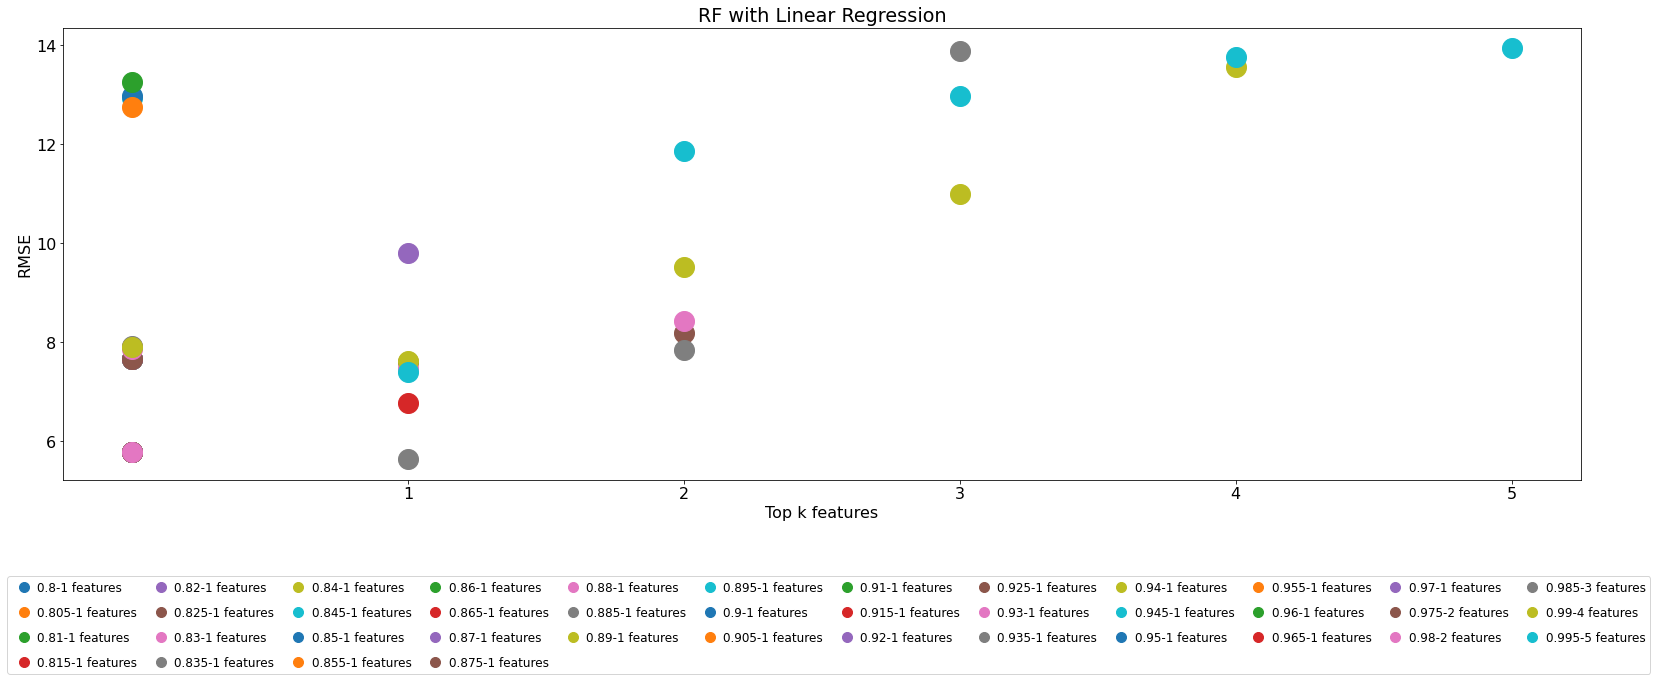

In [53]:
plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = '16'

plt.title("RF with Linear Regression")
for k in li_rfr_error.keys():
    plt.xticks(li_rfr_error[k].index)
    plt.plot(li_rfr_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_rfr_error[k]))+' features',markersize = 20)  
plt.ylabel("RMSE")
plt.xlabel("Top k features") 
plt.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
plt.tight_layout()

In [53]:
def ann_regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))

    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    ann_model = keras.Sequential([
        keras.layers.Dense(500,activation='relu',input_shape=[x_train.shape[1]]),
        keras.layers.Dense(500,activation='relu'),
        keras.layers.Dense(250,activation='relu'),
        keras.layers.Dense(250,activation='relu'),
        keras.layers.Dense(1)])#最后输出为一个结果，也就是预测的值
        #定义损失函数loss，采用的优化器optimizer为Adam
    ann_model.compile(loss='mean_absolute_error',optimizer='Adam')
    
    ann_model.fit(x_train,y_train.reshape(-1,))
    y_ann_model = ann_model.predict(x_test)
    y_ann_model_inverse =minmax_y_test.inverse_transform(y_ann_model.reshape((-1,1)))
    
    print(
          "RandomForest_mae:%f"%(mean_absolute_error(y_ann_model_inverse, Y_test  ))+"\n",
          "RandomForest_rmse:%f"%(sqrt(mean_squared_error(y_ann_model_inverse, Y_test  )))+"\n"
#           "elastic_mse:%f"%(mean_squared_error( y_elastic_inverse, Y_test  )),     
     )
    
    y_df = {
        "Original": Y_test.values,
        'RandomForest_':y_ann_model_inverse
    }
    
    error_metrics = {
        "mae":(mean_absolute_error(y_ann_model_inverse, Y_test  )),
        "rmse":(sqrt(mean_squared_error(y_ann_model_inverse, Y_test  )))
    }
    return error_metrics

In [54]:
ann_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    ann_lgb_error[k] = []
    if type(v)==list:
        ann_lgb_error[k].append(ann_regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        
        ann_lgb_error[k] = pd.DataFrame(ann_lgb_error[k])
        
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            ann_lgb_error[k].append(ann_regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        ann_lgb_error[k] = pd.DataFrame(ann_lgb_error[k],index = list(v.keys()))

ann_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    ann_xgb_error[k] = []
    if type(v)==list:
        ann_xgb_error[k].append(ann_regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        ann_xgb_error[k] = pd.DataFrame(ann_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            ann_xgb_error[k].append(ann_regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        ann_xgb_error[k] = pd.DataFrame(ann_xgb_error[k],index = list(v.keys()))
    
ann_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    ann_rfr_error[k] = []
    if type(v) == list:
        ann_rfr_error[k].append(ann_regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        ann_rfr_error[k] = pd.DataFrame(ann_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            ann_rfr_error[k].append(ann_regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        ann_rfr_error[k] = pd.DataFrame(ann_rfr_error[k],index = list(v.keys()))

0.85
17/17 [==============================] - 1s 4ms/step - loss: 0.1574
RandomForest_mae:76.513717
 RandomForest_rmse:83.620291

0.86
17/17 [==============================] - 0s 4ms/step - loss: 0.1573
RandomForest_mae:75.409325
 RandomForest_rmse:78.571885

0.87
17/17 [==============================] - 0s 5ms/step - loss: 0.1574
RandomForest_mae:119.714374
 RandomForest_rmse:144.683988

0.88
17/17 [==============================] - 0s 4ms/step - loss: 0.1336
RandomForest_mae:120.402062
 RandomForest_rmse:148.769970

0.89
17/17 [==============================] - 0s 5ms/step - loss: 0.1072
RandomForest_mae:91.746945
 RandomForest_rmse:106.944985

0.9
17/17 [==============================] - 0s 5ms/step - loss: 0.1594
RandomForest_mae:100.601888
 RandomForest_rmse:122.770810

0.91
17/17 [==============================] - 0s 4ms/step - loss: 0.1194
RandomForest_mae:77.581650
 RandomForest_rmse:94.182628

0.92
17/17 [==============================] - 1s 5ms/step - loss: 0.1289
RandomFores

17/17 [==============================] - 0s 4ms/step - loss: 0.1613
RandomForest_mae:102.540553
 RandomForest_rmse:113.998276

3 9
17/17 [==============================] - 0s 4ms/step - loss: 0.1706
RandomForest_mae:82.541490
 RandomForest_rmse:91.550508

4 13
17/17 [==============================] - 0s 5ms/step - loss: 0.1261
RandomForest_mae:149.614782
 RandomForest_rmse:160.875032

5 16
17/17 [==============================] - 0s 4ms/step - loss: 0.1307
RandomForest_mae:157.701019
 RandomForest_rmse:181.012447



In [55]:
ann_lgb = join_err(ann_lgb_error)
ann_xgb = join_err(ann_xgb_error)
ann_rfr = join_err(ann_rfr_error)

Min 25.99419433015128
Min 49.16831791029286
Min 38.30952512376498


### Support Vector Regression

In [56]:
def SVR_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    parameters = {'kernel':['rbf'], 'gamma':np.logspace(-5, 0, num=6, base=2.0),'C':np.logspace(-5, 5, num=11, base=2.0)}
    svr =  SVR()
    grid_search = GridSearchCV(svr, parameters, cv=10, n_jobs=4, scoring='neg_mean_squared_error')
    grid_search.fit(x_train,y_train.reshape(-1,))
#     print(grid_search.best_params_)
    y_svr = grid_search.predict(x_test)
    
    y_svr_inverse =minmax_y_test.inverse_transform(y_svr.reshape((-1,1)))
    
    print(
        "rmse: ",sqrt(mean_squared_error(y_svr_inverse,y_test_inverse)),
         "mae:",mean_absolute_error(y_svr_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_svr_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_svr_inverse,y_test_inverse)
    }
    
    return error_metrics

In [55]:
SVR_Regressor(x_train_no,y_train_no,x_test_no,y_test_no)

rmse:  157.43953326887132 mae: 123.37024491531102


{'rmse': 157.43953326887132, 'mae': 123.37024491531102}

In [56]:
SVR_Regressor(x_train,y_train,x_test_L,y_test_L)

rmse:  186.017125568089 mae: 135.01587709083591


{'rmse': 186.017125568089, 'mae': 135.01587709083591}

In [57]:
svr_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    svr_lgb_error[k] = []
    if type(v)==list:
        svr_lgb_error[k].append(SVR_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        svr_lgb_error[k] = pd.DataFrame(svr_lgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            svr_lgb_error[k].append(SVR_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        svr_lgb_error[k] = pd.DataFrame(svr_lgb_error[k],index = list(v.keys()))

svr_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    svr_xgb_error[k] = []
    if type(v)==list:
        svr_xgb_error[k].append(SVR_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        svr_xgb_error[k] = pd.DataFrame(svr_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            svr_xgb_error[k].append(SVR_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        svr_xgb_error[k] = pd.DataFrame(svr_xgb_error[k],index = list(v.keys()))
    
svr_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    svr_rfr_error[k] = []
    if type(v) == list:
        svr_rfr_error[k].append(SVR_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        svr_rfr_error[k] = pd.DataFrame(svr_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            svr_rfr_error[k].append(SVR_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        svr_rfr_error[k] = pd.DataFrame(svr_rfr_error[k],index = list(v.keys()))

0.85
rmse:  46.72291746248986 mae: 37.05875713241258
0.86
rmse:  49.32305727333677 mae: 40.54418991994135
0.87
rmse:  79.192630857521 mae: 64.24603698555235
0.88
rmse:  89.46304432258165 mae: 69.76868078347042
0.89
rmse:  89.46304432258165 mae: 69.76868078347042
0.9
rmse:  89.46304432258165 mae: 69.76868078347042
0.91
rmse:  68.82600054947162 mae: 57.86156919777934
0.92
rmse:  71.56241830175674 mae: 59.71651387534049
0.93
rmse:  33.902389612116096 mae: 26.32430594976804
0.94
1 3
rmse:  86.59848138017627 mae: 60.10076754051475
0.95
1 2
rmse:  45.04259510320862 mae: 35.76877671391422
0.96
1 2
rmse:  45.93561470452405 mae: 36.50638249310299
0.97
1 2
rmse:  45.93561470452405 mae: 36.50638249310299
2 5
rmse:  100.58343462461328 mae: 81.80240734866116
0.98
1 3
rmse:  31.614366261165024 mae: 22.665000307422392
2 8
rmse:  88.88340426219274 mae: 72.04279662283633
3 10
rmse:  56.687779159415044 mae: 41.77727873040972
0.99
1 5
rmse:  59.97895657803104 mae: 44.21707895567347
2 9
rmse:  64.80300404

In [58]:
svr_lgb = join_err(svr_lgb_error)
svr_xgb = join_err(svr_xgb_error)
svr_rfr = join_err(svr_rfr_error)

Min 31.614366261165024
Min 33.902389612116096
Min 33.902389612116096


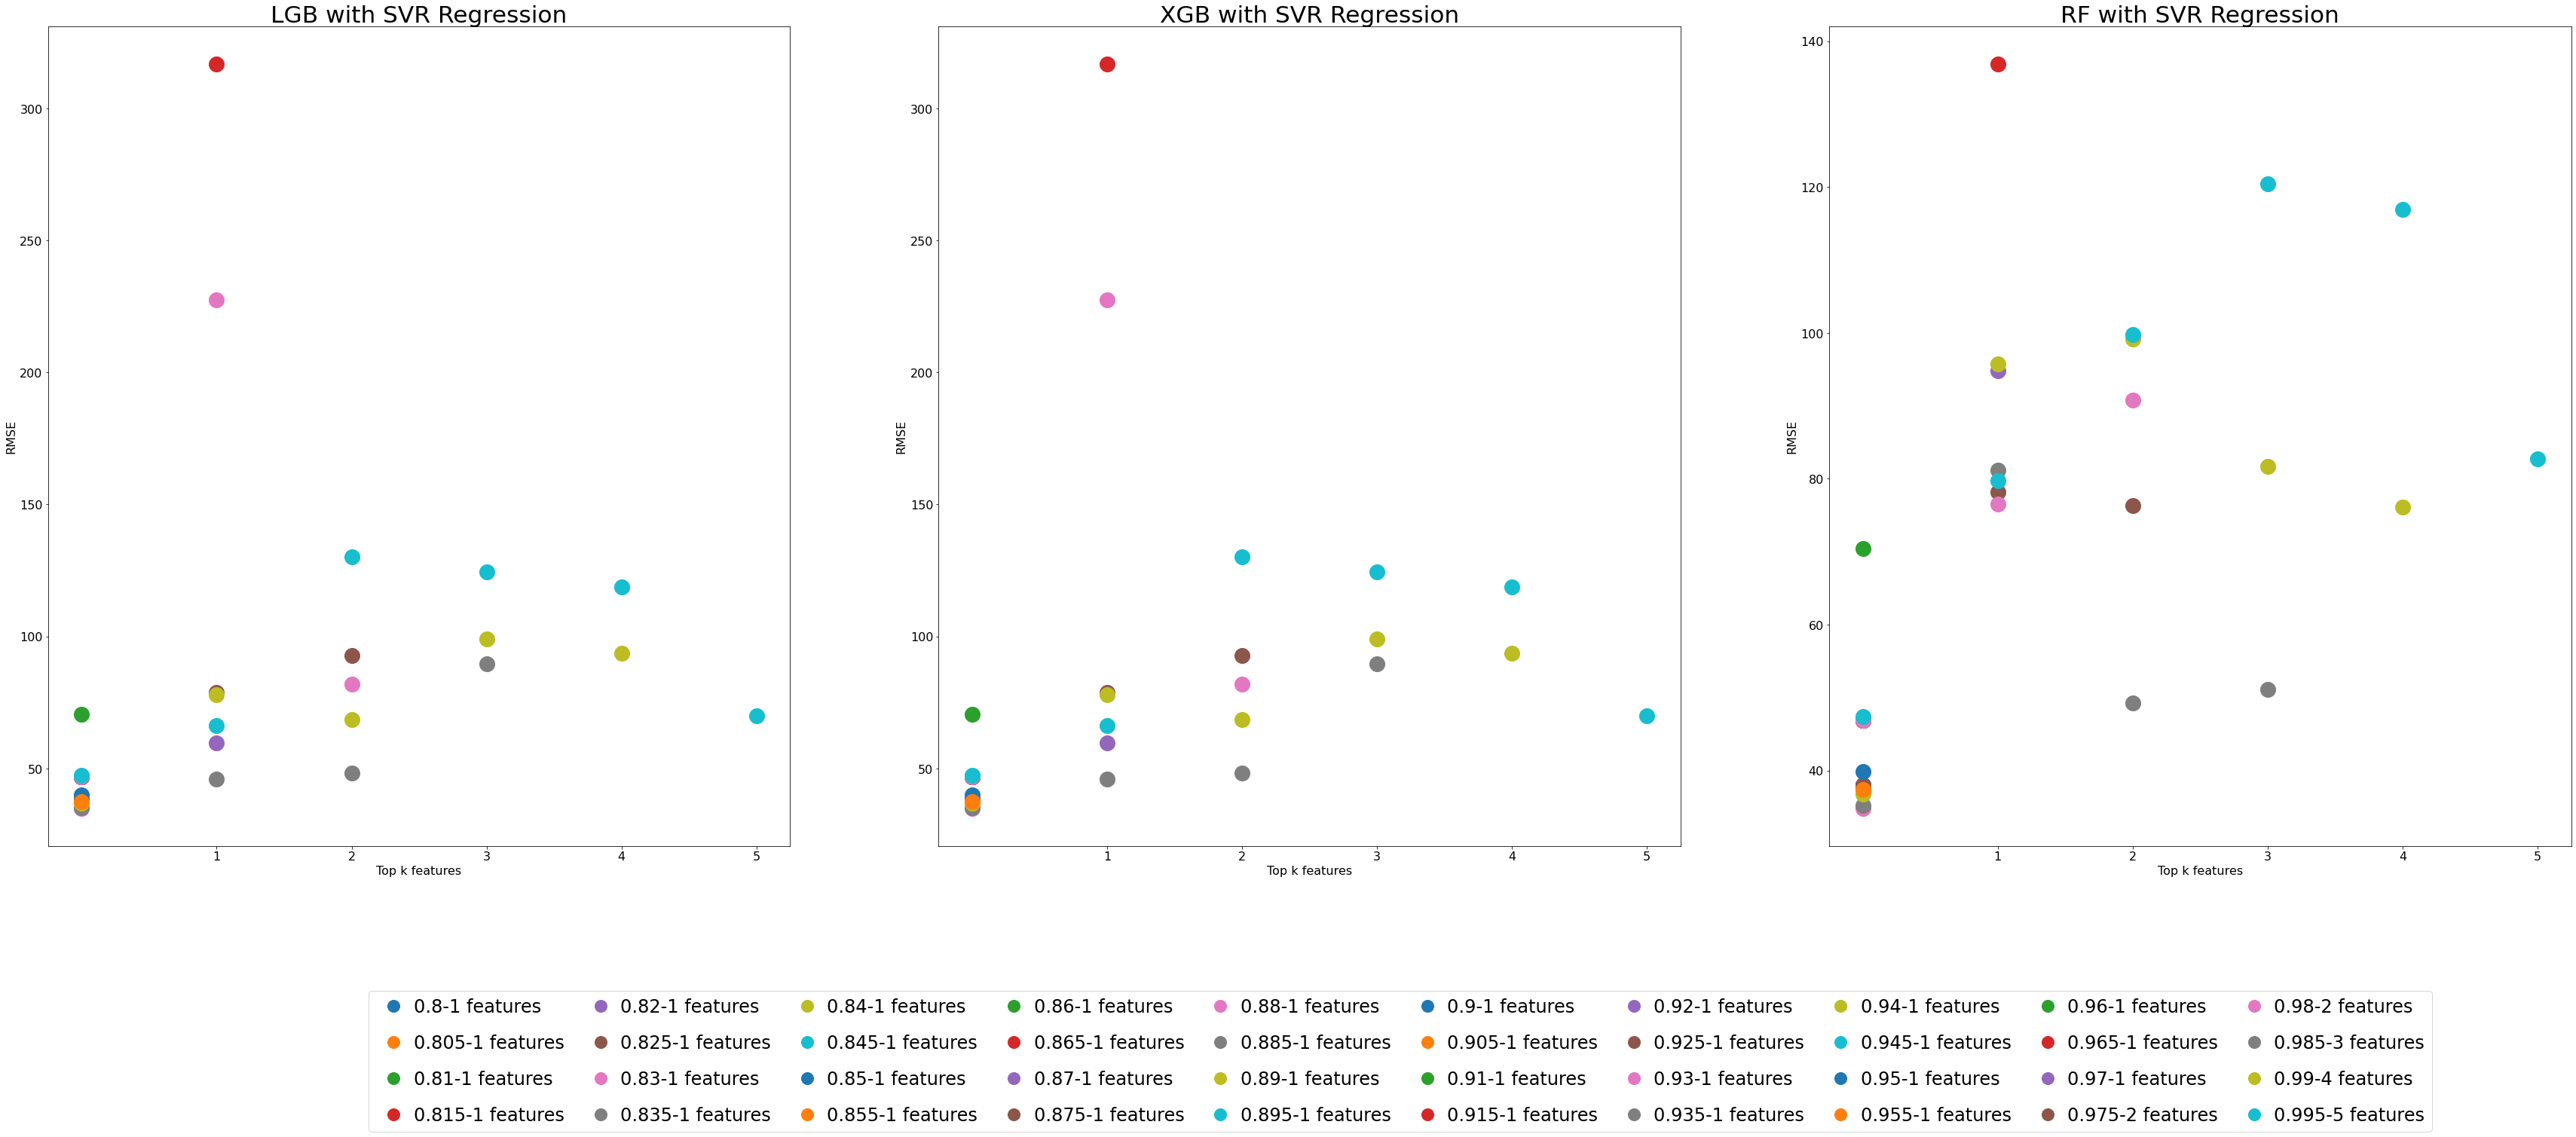

In [59]:
fig,ax = plt.subplots(1,3,figsize=(60,20))

plt.rcParams['font.size'] = '26'

ax[0].set_title("LGB with SVR Regression")
for k in svr_lgb_error .keys():
    ax[0].set_xticks(svr_lgb_error[k].index)
    ax[0].plot(svr_lgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(svr_lgb_error[k]))+' features',markersize = 20) 
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("Top k features") 
# ax[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
ax[0].set_visible(True)


ax[1].set_title("XGB with SVR Regression")
for k in svr_xgb_error .keys():
    ax[1].set_xticks(svr_xgb_error[k].index)
    ax[1].plot(svr_xgb_error[k]['rmse'],'o',markersize = 20) 
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Top k features") 

ax[2].set_title("RF with SVR Regression")
for k in svr_rfr_error.keys():
    ax[2].set_xticks(svr_rfr_error[k].index)
    ax[2].plot(svr_rfr_error[k]['rmse'],'o',markersize = 20)  
ax[2].set_ylabel("RMSE")
ax[2].set_xlabel("Top k features") 

fig.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.86, 0),ncol=10,handletextpad=0.1,fontsize=24)

In [60]:
def xgb_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    
    xgb = XGBRegressor(n_jobs=-1, n_estimators=100, max_depth=4, random_state=99)
    xgb.fit(x_train,y_train.reshape(-1,))
    y_xgb = xgb.predict(x_test)
    y_xgb_inverse =minmax_y_test.inverse_transform(y_xgb.reshape((-1,1)))
    
    print(
        "rmse: ",sqrt(mean_squared_error(y_xgb_inverse,y_test_inverse)),
         "mae:",mean_absolute_error(y_xgb_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_xgb_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_xgb_inverse,y_test_inverse)
    }
    
    return error_metrics

In [61]:
xgb_Regressor(x_train_no,y_train_no,x_test_no,y_test_no)

rmse:  27.587934087149854 mae: 21.49930882352936


{'rmse': 27.587934087149854, 'mae': 21.49930882352936}

In [62]:
xgb_Regressor(x_train_L,y_train_L,x_test_L,y_test_L)

rmse:  144.82196646666296 mae: 92.76183487857676


{'rmse': 144.82196646666296, 'mae': 92.76183487857676}

In [63]:
xgb_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    xgb_lgb_error[k] = []
    if type(v)==list:
        xgb_lgb_error[k].append(xgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        xgb_lgb_error[k] = pd.DataFrame(xgb_lgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            xgb_lgb_error[k].append(xgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        xgb_lgb_error[k] = pd.DataFrame(xgb_lgb_error[k],index = list(v.keys()))

xgb_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    xgb_xgb_error[k] = []
    if type(v)==list:
        xgb_xgb_error[k].append(xgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        xgb_xgb_error[k] = pd.DataFrame(xgb_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            xgb_xgb_error[k].append(xgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        xgb_xgb_error[k] = pd.DataFrame(xgb_xgb_error[k],index = list(v.keys()))
    
xgb_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    xgb_rfr_error[k] = []
    if type(v) == list:
        xgb_rfr_error[k].append(xgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        xgb_rfr_error[k] = pd.DataFrame(xgb_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            xgb_rfr_error[k].append(xgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        xgb_rfr_error[k] = pd.DataFrame(xgb_rfr_error[k],index = list(v.keys()))

0.8
rmse:  13.969985023742659 mae: 10.93149708207829
0.805
rmse:  13.969985023742659 mae: 10.93149708207829
0.81
rmse:  13.969985023742659 mae: 10.93149708207829
0.815
rmse:  13.969985023742659 mae: 10.93149708207829
0.82
rmse:  13.969985023742659 mae: 10.93149708207829
0.825
rmse:  13.969985023742659 mae: 10.93149708207829
0.83
rmse:  13.969985023742659 mae: 10.93149708207829
0.835
rmse:  13.969985023742659 mae: 10.93149708207829
0.84
rmse:  13.969985023742659 mae: 10.93149708207829
0.845
rmse:  13.969985023742659 mae: 10.93149708207829
0.85
rmse:  13.969985023742659 mae: 10.93149708207829
0.855
rmse:  13.969985023742659 mae: 10.93149708207829
0.86
rmse:  13.969985023742659 mae: 10.93149708207829
0.865
rmse:  13.969985023742659 mae: 10.93149708207829
0.87
rmse:  13.969985023742659 mae: 10.93149708207829
0.875
rmse:  13.969985023742659 mae: 10.93149708207829
0.88
rmse:  13.969985023742659 mae: 10.93149708207829
0.885
rmse:  14.474903502768742 mae: 11.58598585749244
0.89
rmse:  14.47490

rmse:  151.5183978056525 mae: 90.18426546027858
4 13
rmse:  112.3404930104574 mae: 75.51391707454816
5 15
rmse:  143.63314753672617 mae: 91.55751870764306


In [64]:
avg_xgb_lgb = avg_rmse(xgb_lgb_error)
avg_xgb_xgb = avg_rmse(xgb_xgb_error)
avg_xgb_rfr = avg_rmse(xgb_rfr_error)

avg_xgb_lgb,avg_xgb_xgb,avg_xgb_rfr 

(38.628, 38.628, 43.709)

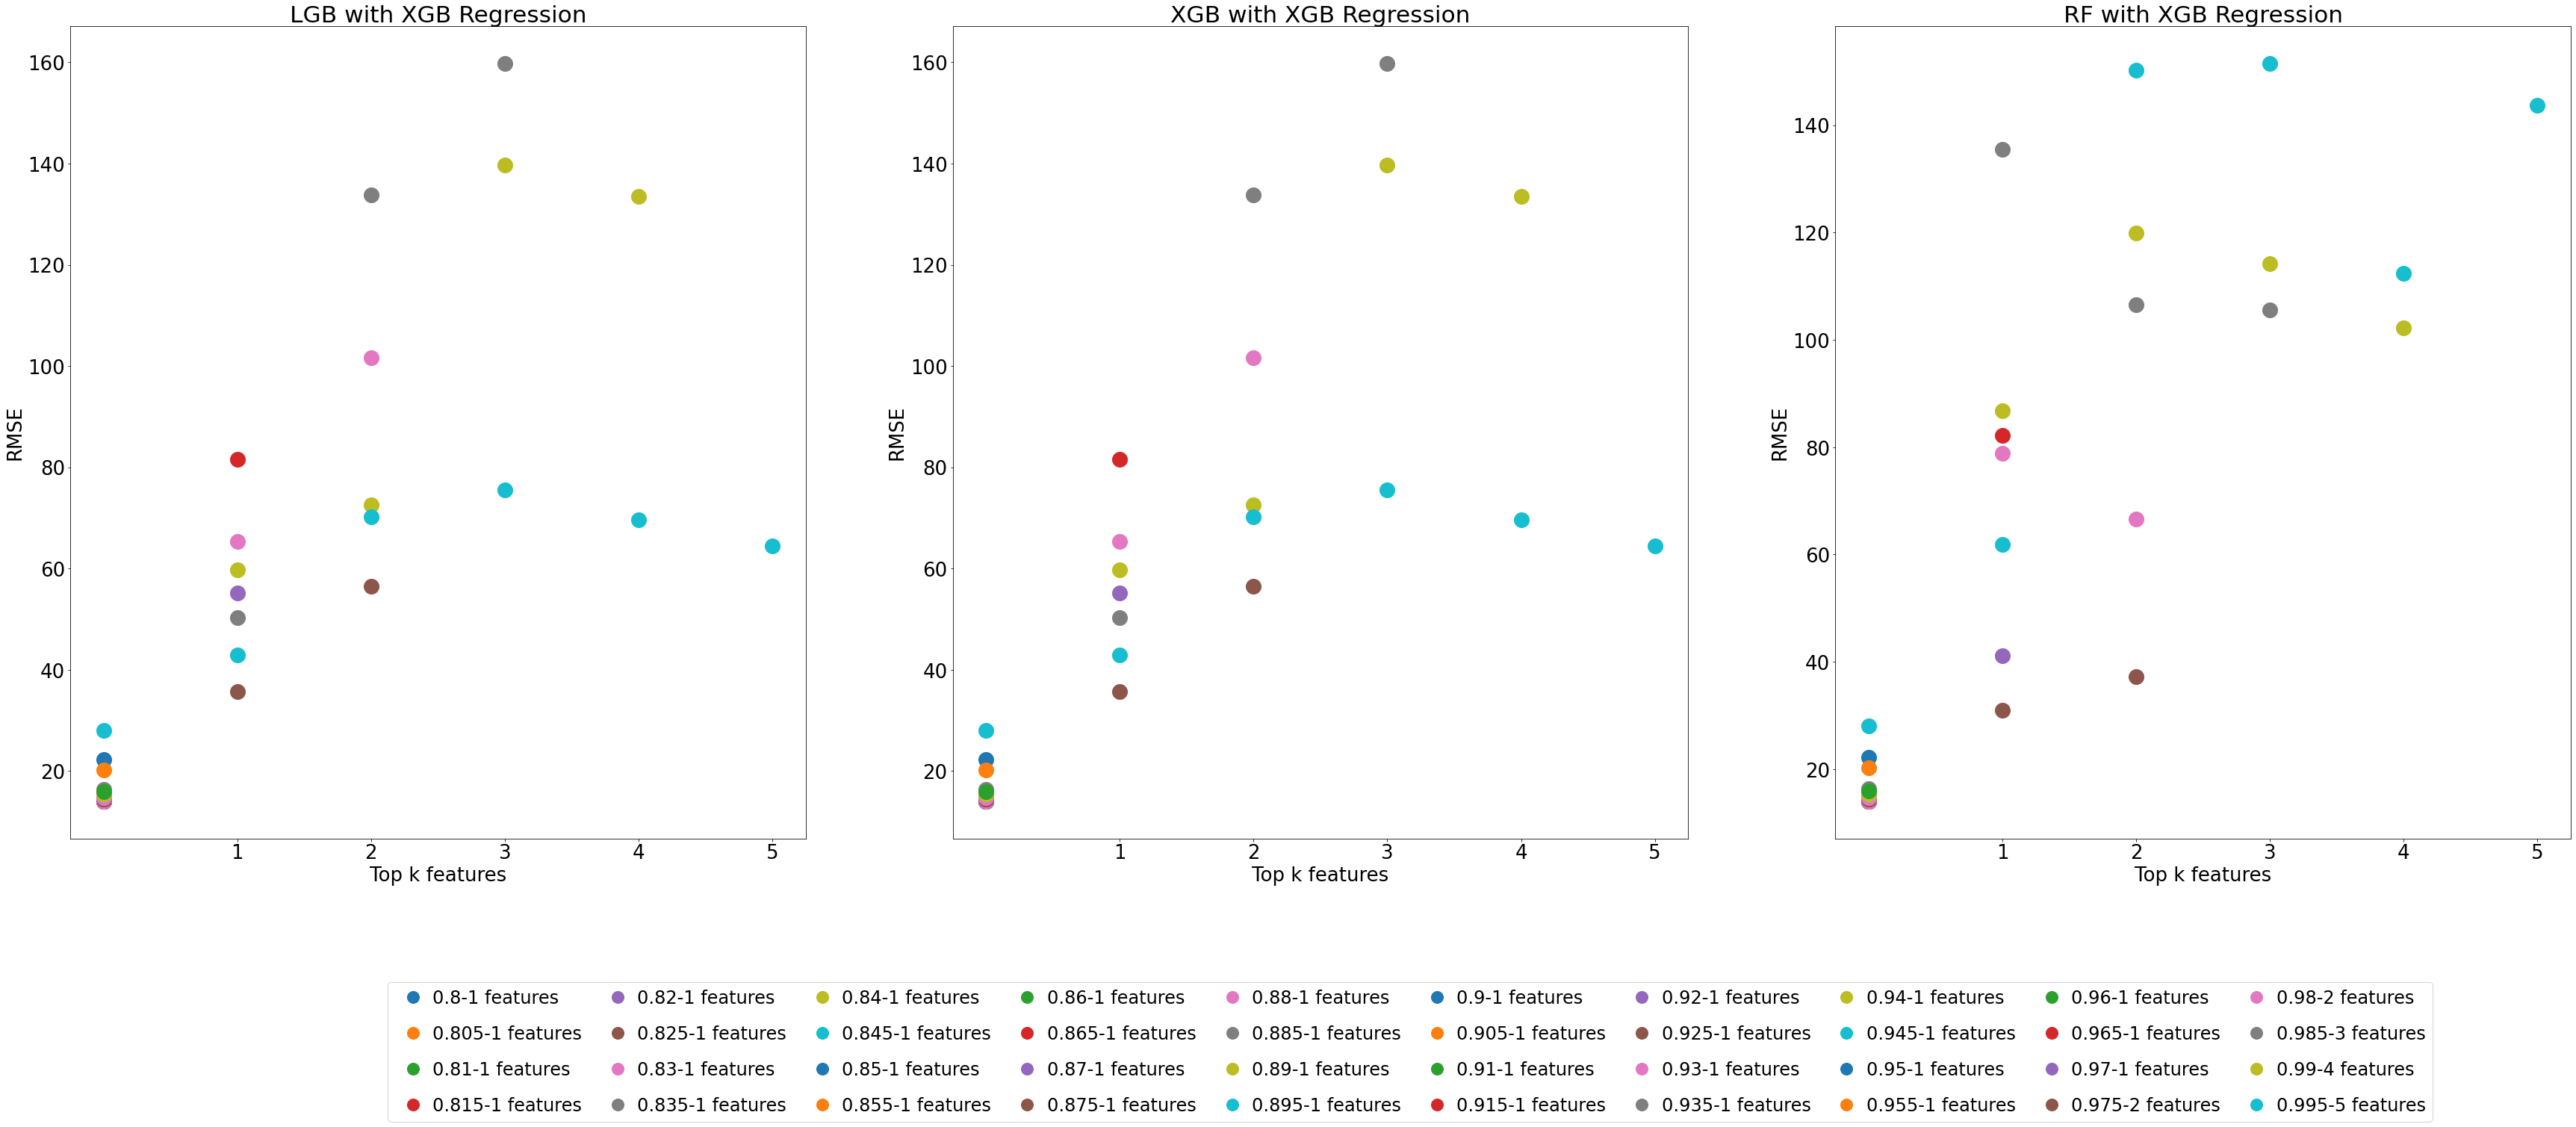

In [65]:
fig,ax = plt.subplots(1,3,figsize=(60,20))

plt.rcParams['font.size'] = '26'

ax[0].set_title("LGB with XGB Regression")
for k in xgb_lgb_error .keys():
    ax[0].set_xticks(xgb_lgb_error[k].index)
    ax[0].plot(xgb_lgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(xgb_lgb_error[k]))+' features',markersize = 20) 
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("Top k features") 
# ax[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
ax[0].set_visible(True)


ax[1].set_title("XGB with XGB Regression")
for k in xgb_xgb_error .keys():
    ax[1].set_xticks(xgb_xgb_error[k].index)
    ax[1].plot(xgb_xgb_error[k]['rmse'],'o',markersize = 20) 
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Top k features") 

ax[2].set_title("RF with XGB Regression")
for k in xgb_rfr_error.keys():
    ax[2].set_xticks(xgb_rfr_error[k].index)
    ax[2].plot(xgb_rfr_error[k]['rmse'],'o',markersize = 20)  
ax[2].set_ylabel("RMSE")
ax[2].set_xlabel("Top k features") 

fig.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.86, 0),ncol=10,handletextpad=0.1,fontsize=24)

In [66]:
def lgb_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    
    gbm = lgb.LGBMRegressor()
    gbm.fit(x_train, y_train)
    y_gbm = gbm.predict(x_test)
    y_gbm_inverse =minmax_y_test.inverse_transform(y_gbm.reshape((-1,1)))
    
    print(
        "rmse: ",sqrt(mean_squared_error(y_gbm_inverse,y_test_inverse)),
         "mae:",mean_absolute_error(y_gbm_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_gbm_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_gbm_inverse,y_test_inverse)
    }
    
    
    return error_metrics

In [67]:
lgb_Regressor(x_train_no,y_train_no,x_test_no,y_test_no)

rmse:  29.950112814622244 mae: 24.29387584542537


{'rmse': 29.950112814622244, 'mae': 24.29387584542537}

In [68]:
lgb_Regressor(x_train_L,y_train_L,x_test_L,y_test_L)

rmse:  105.24245785245749 mae: 80.23182228300752


{'rmse': 105.24245785245749, 'mae': 80.23182228300752}

In [69]:
lgb_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    lgb_lgb_error[k] = []
    if type(v)==list:
        lgb_lgb_error[k].append(lgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        lgb_lgb_error[k] = pd.DataFrame(lgb_lgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            lgb_lgb_error[k].append(lgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        lgb_lgb_error[k] = pd.DataFrame(lgb_lgb_error[k],index = list(v.keys()))

lgb_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    lgb_xgb_error[k] = []
    if type(v)==list:
        lgb_xgb_error[k].append(lgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        lgb_xgb_error[k] = pd.DataFrame(lgb_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            lgb_xgb_error[k].append(lgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        lgb_xgb_error[k] = pd.DataFrame(lgb_xgb_error[k],index = list(v.keys()))
    
lgb_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    lgb_rfr_error[k] = []
    if type(v) == list:
        lgb_rfr_error[k].append(lgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        lgb_rfr_error[k] = pd.DataFrame(lgb_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            lgb_rfr_error[k].append(lgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        lgb_rfr_error[k] = pd.DataFrame(lgb_rfr_error[k],index = list(v.keys()))

0.8
rmse:  16.10398019013955 mae: 12.460070458350522
0.805
rmse:  16.10398019013955 mae: 12.460070458350522
0.81
rmse:  16.10398019013955 mae: 12.460070458350522
0.815
rmse:  16.10398019013955 mae: 12.460070458350522
0.82
rmse:  16.10398019013955 mae: 12.460070458350522
0.825
rmse:  16.10398019013955 mae: 12.460070458350522
0.83
rmse:  16.10398019013955 mae: 12.460070458350522
0.835
rmse:  16.10398019013955 mae: 12.460070458350522
0.84
rmse:  16.10398019013955 mae: 12.460070458350522
0.845
rmse:  16.10398019013955 mae: 12.460070458350522
0.85
rmse:  16.10398019013955 mae: 12.460070458350522
0.855
rmse:  16.10398019013955 mae: 12.460070458350522
0.86
rmse:  16.10398019013955 mae: 12.460070458350522
0.865
rmse:  16.10398019013955 mae: 12.460070458350522
0.87
rmse:  16.10398019013955 mae: 12.460070458350522
0.875
rmse:  16.10398019013955 mae: 12.460070458350522
0.88
rmse:  16.10398019013955 mae: 12.460070458350522
0.885
rmse:  18.07087879864082 mae: 14.690479741528058
0.89
rmse:  18.07087

rmse:  68.87483108685748 mae: 50.02417291158921
5 15
rmse:  70.17503312767731 mae: 59.365906639363715


In [70]:
avg_lgb_lgb = avg_rmse(lgb_lgb_error)
avg_lgb_xgb = avg_rmse(lgb_xgb_error)
avg_lgb_rfr = avg_rmse(lgb_rfr_error)

avg_lgb_lgb,avg_lgb_xgb,avg_lgb_rfr 

(29.58, 29.58, 29.649)

In [52]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [1]:
plt.rcParams['font.size'] = '40'
fig,axes = plt.subplots(5,3,figsize=(100,60),dpi = 600,constrained_layout=True)

axes[0,0].set_title("LGB with Random Forest Regression")
for k in rfr_lgb_error .keys():
    axes[0,0].set_xticks(rfr_lgb_error[k].index)
    axes[0,0].plot(rfr_lgb_error[k]['rmse'],'o',markersize = 30) 
axes[0,0].set_visible(True)

axes[0,1].set_title("XGB with Random Forest Regression")
for k in rfr_xgb_error .keys():
    axes[0,1].set_xticks(rfr_xgb_error[k].index)
    axes[0,1].plot(rfr_xgb_error[k]['rmse'],'o',markersize = 30) 

axes[0,2].set_title("RF with Random Forest Regression")
for k in rfr_rfr_error.keys():
    axes[0,2].set_xticks(rfr_rfr_error[k].index)
    axes[0,2].plot(rfr_rfr_error[k]['rmse'],'o',markersize = 30)  


axes[1,0].set_title("LGB with Linear Regression")
for k in li_lgb_error .keys():
    axes[1,0].set_xticks(li_lgb_error[k].index)
    axes[1,0].plot(li_lgb_error[k]['rmse'],'o',markersize=30) 

# axes[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
axes[1,0].set_visible(True)


axes[1,1].set_title("XGB with Linear Regression")
for k in li_xgb_error .keys():
    axes[1,1].set_xticks(li_xgb_error[k].index)
    axes[1,1].plot(li_xgb_error[k]['rmse'],'o',markersize = 30) 


axes[1,2].set_title("RF with Linear Regression")
for k in li_rfr_error.keys():
    axes[1,2].set_xticks(li_rfr_error[k].index)
    axes[1,2].plot(li_rfr_error[k]['rmse'],'o',markersize = 30)  
axes[1,2].set_ylabel("RMSE")
axes[1,2].set_xlabel("Top k features") 


axes[2,0].set_title("LGB with SVR Regression")
for k in svr_lgb_error .keys():
    axes[2,0].set_xticks(svr_lgb_error[k].index)
    axes[2,0].plot(svr_lgb_error[k]['rmse'],'o',markersize = 30) 

axes[2,0].set_visible(True)


axes[2,1].set_title("XGB with SVR Regression")
for k in svr_xgb_error .keys():
    axes[2,1].set_xticks(svr_xgb_error[k].index)
    axes[2,1].plot(svr_xgb_error[k]['rmse'],'o',markersize = 30) 
 

axes[2,2].set_title("RF with SVR Regression")
for k in svr_rfr_error.keys():
    axes[2,2].set_xticks(svr_rfr_error[k].index)
    axes[2,2].plot(svr_rfr_error[k]['rmse'],'o',markersize = 30)  


axes[3,0].set_title("LGB with XGB Regression")
for k in xgb_lgb_error .keys():
    axes[3,0].set_xticks(xgb_lgb_error[k].index)
    axes[3,0].plot(xgb_lgb_error[k]['rmse'],'o',markersize = 30) 


axes[3,0].set_visible(True)


axes[4,1].set_title("XGB with XGB Regression")
for k in xgb_xgb_error .keys():
    axes[3,1].set_xticks(xgb_xgb_error[k].index)
    axes[3,1].plot(xgb_xgb_error[k]['rmse'],'o',markersize = 30) 


axes[3,2].set_title("RF with XGB Regression")
for k in xgb_rfr_error.keys():
    axes[3,2].set_xticks(xgb_rfr_error[k].index)
    axes[3,2].plot(xgb_rfr_error[k]['rmse'],'o',markersize = 30)  


axes[4,0].set_title("LGB with LGB Regression")
for k in lgb_lgb_error .keys():
    axes[4,0].set_xticks(lgb_lgb_error[k].index)
    axes[4,0].plot(lgb_lgb_error[k]['rmse'],'o',markersize = 30) 

# axes[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
axes[4,0].set_visible(True)


axes[4,1].set_title("XGB with LGB Regression")
for k in lgb_xgb_error.keys():
    axes[4,1].set_xticks(lgb_xgb_error[k].index)
    axes[4,1].plot(lgb_xgb_error[k]['rmse'],'o',markersize = 30) 
 
axes[4,2].set_title("RF with LGB Regression")
for k in lgb_rfr_error.keys():
    axes[4,2].set_xticks(lgb_rfr_error[k].index)
    axes[4,2].plot(lgb_rfr_error[k]['rmse'],'o',markersize = 30)  

fig.tight_layout()
fig.text(0.5, -0.02, 'Top k features', ha='center',fontsize=50)
fig.text(-0.02, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=50)
fig.legend(list(real_lgb.keys()),scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.8,-0.03),ncol=10,handletextpad=4,fontsize=50)
plt.savefig('rmse_diamond.png')
plt.show()

NameError: name 'plt' is not defined